## ABC-SMC (omm12 dataset): logistic growth, immigration, and death

## Hide or show code

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle on/off the raw code."></form>''')

## Import packages

In [2]:
%matplotlib inline

import matplotlib.pyplot as mp
import numpy as np
import scipy as sp
import pickle as pc

from random import random
from datetime import timedelta

from pyabc import ABCSMC, RV, Distribution, MultivariateNormalTransition, QuantileEpsilon, LocalTransition, History
from pyabc.transition import silverman_rule_of_thumb
from pyabc.populationstrategy import AdaptivePopulationSize, ListPopulationSize
from pyabc.visualization import plot_kde_matrix
from pyabc.sampler import SingleCoreSampler

import matplotlib.lines as mlines

from matplotlib import rc
rc('xtick', labelsize=14)
rc('ytick', labelsize=14)
mp.rcParams['figure.figsize'] = (4, 4)

from sc_logistic_numerics import model_abs_abund_closure_from_2nd as logistic_model_abs_abund
from sc_logistic_numerics import model_rel_abund_closure_from_2nd as logistic_model_rel_abund

# import warnings
# warnings.filterwarnings('ignore')

db_path_abs_abund = "sqlite:///../data/omm12/logistic_inference_abs_abund.db"
db_path_rel_abund = "sqlite:///../data/omm12/logistic_inference_rel_abund.db"

## Define a "distance" metric

In [3]:
def distance_abs_abund(predicted_moments_abs_abund, empirical_moments_abs_abund):
    
    empirical_data = empirical_moments_abs_abund["moments"]
    predicted_data = predicted_moments_abs_abund["moments"]
    
    # Compute the distance metric
    criteria = np.sqrt(((empirical_data - predicted_data)**2).sum())
    
    if criteria < 1.5E14: print(criteria)
    
    return criteria

def distance_rel_abund(predicted_moments_rel_abund, empirical_moments_rel_abund):
    
    empirical_data = empirical_moments_rel_abund["moments"]
    predicted_data = predicted_moments_rel_abund["moments"][:,:-1]
    
    # Compute the distance metric
    criteria = np.sqrt(((empirical_data - predicted_data)**2).sum())
        
    return criteria

## Import simulated data and numerics

In [4]:
with open('../data/omm12/experimental_abs_abund.pickle', 'rb') as f: 
    omm12_abs_abund = pc.load(f)
n_types = omm12_abs_abund['n_types']
sampling_times = omm12_abs_abund['sampling_times']
t_points = omm12_abs_abund['t_points']
n_timeseries = omm12_abs_abund['n_timeseries']
omm12_abs_abund = omm12_abs_abund['data']

with open('../data/omm12/experimental_rel_abund.pickle', 'rb') as f: 
    omm12_rel_abund = pc.load(f)
omm12_rel_abund = omm12_rel_abund['data']

## Plot abundance data

Absolute abundance

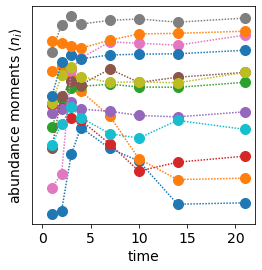

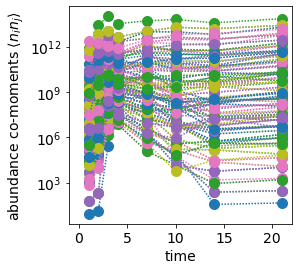

In [5]:
## Absolute abundance

# Plot moments

m_k = omm12_abs_abund["moments"][:,:n_types]

mp.semilogy(sampling_times, m_k, 'o', '.-', linestyle=(0,(1,1)), markersize=10)
# Annotate
mp.xlabel('time', fontsize=14)
mp.ylabel(r'abundance moments $\langle n_i \rangle$', fontsize=14)
mp.show();

# Plot co-moments

cm_kj = omm12_abs_abund["moments"][:,n_types:]

for k in range(n_types**2):
        mp.semilogy(sampling_times, cm_kj[:,k], 'o', '.-', linestyle=(0,(1,1)), markersize=10)
# Annotate
mp.xlabel('time', fontsize=14)
mp.ylabel(r'abundance co-moments $\langle n_i n_j \rangle$', fontsize=14)
mp.show();

Relative abundance

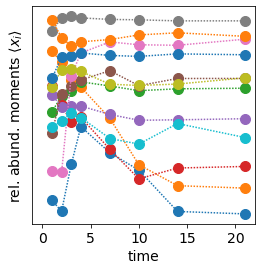

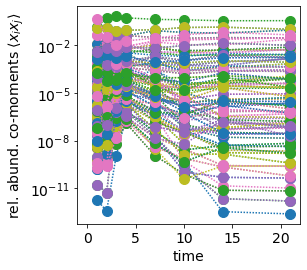

In [6]:
## Relative abundance

# Plot moments

m_k = omm12_rel_abund["moments"][:,:n_types]

mp.semilogy(sampling_times, m_k, 'o', '.-', linestyle=(0,(1,1)), markersize=10)
# Annotate
mp.xlabel('time', fontsize=14)
mp.ylabel(r'rel. abund. moments $\langle x_i \rangle$', fontsize=14)
mp.show();

# Plot co-moments

cm_kj = omm12_rel_abund["moments"][:,n_types:]

for k in range(n_types**2):
        mp.semilogy(sampling_times, cm_kj[:,k], 'o', '.-', linestyle=(0,(1,1)), markersize=10)
# Annotate
mp.xlabel('time', fontsize=14)
mp.ylabel(r'rel. abund. co-moments $\langle x_i x_j \rangle$', fontsize=14)
mp.show();

## Inference

Define the priors

In [7]:
gR_names = ["gR_%i"%i for i in range(n_types)]
dR_names = ["dR_%i"%i for i in range(n_types)]
mR_names = ["mR_%i"%i for i in range(n_types)]
N_names = ["N"]
mSigma_names = ["mSigma[0]"]

# Growth rates
gR_prior = n_types * [("uniform", 0.25, 72)]
# Death rates
dR_prior = n_types * [("uniform", 0, 2E6)]
# Immigration rates
mR_prior = n_types * [("uniform", 0, 2E6)]
# Carrying capacity
N_prior = [("uniform", 1.4E7, 2E6)]
# Scaling factor
mSigma_prior = [("uniform", 1E6, 9E6)]

parameter_names = gR_names + dR_names + mR_names + N_names + mSigma_names
priors_shapes = gR_prior + dR_prior + mR_prior + N_prior + mSigma_prior
priors_dict = dict(zip(parameter_names, priors_shapes))

priors = Distribution(**{key: RV(a, b, c) for key, (a, b, c) in priors_dict.items()})

print(priors_dict)

{'gR_0': ('uniform', 0.25, 72), 'gR_1': ('uniform', 0.25, 72), 'gR_2': ('uniform', 0.25, 72), 'gR_3': ('uniform', 0.25, 72), 'gR_4': ('uniform', 0.25, 72), 'gR_5': ('uniform', 0.25, 72), 'gR_6': ('uniform', 0.25, 72), 'gR_7': ('uniform', 0.25, 72), 'gR_8': ('uniform', 0.25, 72), 'gR_9': ('uniform', 0.25, 72), 'gR_10': ('uniform', 0.25, 72), 'gR_11': ('uniform', 0.25, 72), 'dR_0': ('uniform', 0, 2000000.0), 'dR_1': ('uniform', 0, 2000000.0), 'dR_2': ('uniform', 0, 2000000.0), 'dR_3': ('uniform', 0, 2000000.0), 'dR_4': ('uniform', 0, 2000000.0), 'dR_5': ('uniform', 0, 2000000.0), 'dR_6': ('uniform', 0, 2000000.0), 'dR_7': ('uniform', 0, 2000000.0), 'dR_8': ('uniform', 0, 2000000.0), 'dR_9': ('uniform', 0, 2000000.0), 'dR_10': ('uniform', 0, 2000000.0), 'dR_11': ('uniform', 0, 2000000.0), 'mR_0': ('uniform', 0, 2000000.0), 'mR_1': ('uniform', 0, 2000000.0), 'mR_2': ('uniform', 0, 2000000.0), 'mR_3': ('uniform', 0, 2000000.0), 'mR_4': ('uniform', 0, 2000000.0), 'mR_5': ('uniform', 0, 20000

Define settings for inference

In [8]:
# Settings for inference

### For ABCSMC function

## For population size

# Number of samples in the first generation
start_nr_particles_p = 2000

# CV criterion (smaller values lead to more samples per generation)
mean_cv_p = 0.25

# Number of samples to estimate the eps in first generation
nr_calibration_particles_p = 400

# Number of bootstrapped samples to estimate the CV of a generation
n_bootstrap_p = 2

# Minimum number of samples allowed in a generation
min_population_size_p = 500

# Maximum number of samples allowed in a generation
max_population_size_p = 1000

## For transitions

# Factor to multiply the covariance with
scaling_p = 1.

## For eps

# Initial eps (if ='from sample', eps will be calculated from the prior)
initial_epsilon_p = 'from_sample'

# Quantile for cut-off of samples within a generation (e.g. 0.1 means top 10%)
alpha_p = 0.1

# Factor to multiply the quantile with
quantile_multiplier_p = 1.

### For running ABCSMC function

## Stopping criterion: minimum eps
minimum_epsilon_abs_abund_p = 1E13

## Stopping criterion: minimum eps
minimum_epsilon_rel_abund_p = 1E-1

## Stopping criterion: maximum number of generations
max_nr_populations_p = 6

## Stopping criterion: maximum computing time
max_walltime_p = timedelta(minutes=6*720)

Save settings for inference

In [9]:
with open('../data/omm12/logistic_inference_parameters.pickle', 'wb') as f:
    inference_dict = {'priors_dict': priors_dict, 'start_nr_particles_p': start_nr_particles_p, 'mean_cv_p': mean_cv_p, 'nr_calibration_particles_p': nr_calibration_particles_p, 'n_bootstrap_p': n_bootstrap_p, 'min_population_size_p': min_population_size_p, 'max_population_size_p': max_population_size_p, 'scaling_p': scaling_p, 'initial_epsilon_p': initial_epsilon_p, 'alpha_p': alpha_p, 'quantile_multiplier_p': quantile_multiplier_p, 'minimum_epsilon_abs_abund_p': minimum_epsilon_abs_abund_p, 'minimum_epsilon_rel_abund_p': minimum_epsilon_rel_abund_p, 'max_nr_populations_p': max_nr_populations_p, 'max_walltime_p': max_walltime_p}
    pc.dump(inference_dict, f)

print(inference_dict)

{'priors_dict': {'gR_0': ('uniform', 0.25, 72), 'gR_1': ('uniform', 0.25, 72), 'gR_2': ('uniform', 0.25, 72), 'gR_3': ('uniform', 0.25, 72), 'gR_4': ('uniform', 0.25, 72), 'gR_5': ('uniform', 0.25, 72), 'gR_6': ('uniform', 0.25, 72), 'gR_7': ('uniform', 0.25, 72), 'gR_8': ('uniform', 0.25, 72), 'gR_9': ('uniform', 0.25, 72), 'gR_10': ('uniform', 0.25, 72), 'gR_11': ('uniform', 0.25, 72), 'dR_0': ('uniform', 0, 2000000.0), 'dR_1': ('uniform', 0, 2000000.0), 'dR_2': ('uniform', 0, 2000000.0), 'dR_3': ('uniform', 0, 2000000.0), 'dR_4': ('uniform', 0, 2000000.0), 'dR_5': ('uniform', 0, 2000000.0), 'dR_6': ('uniform', 0, 2000000.0), 'dR_7': ('uniform', 0, 2000000.0), 'dR_8': ('uniform', 0, 2000000.0), 'dR_9': ('uniform', 0, 2000000.0), 'dR_10': ('uniform', 0, 2000000.0), 'dR_11': ('uniform', 0, 2000000.0), 'mR_0': ('uniform', 0, 2000000.0), 'mR_1': ('uniform', 0, 2000000.0), 'mR_2': ('uniform', 0, 2000000.0), 'mR_3': ('uniform', 0, 2000000.0), 'mR_4': ('uniform', 0, 2000000.0), 'mR_5': ('un

#### Absolute abundance

Create ABC-SMC function (consult pyABC documentation for details)

In [10]:
abc_abs_abund = ABCSMC(
    models=logistic_model_abs_abund,
    parameter_priors=priors,
    distance_function=distance_abs_abund,
    population_size=AdaptivePopulationSize(start_nr_particles=start_nr_particles_p, mean_cv = mean_cv_p, nr_calibration_particles=nr_calibration_particles_p, n_bootstrap=n_bootstrap_p, min_population_size = min_population_size_p, max_population_size = max_population_size_p),
    transitions=MultivariateNormalTransition(scaling=scaling_p, bandwidth_selector=silverman_rule_of_thumb),
    eps=QuantileEpsilon(initial_epsilon=initial_epsilon_p, alpha=alpha_p, quantile_multiplier=quantile_multiplier_p),
)

ABC.Sampler INFO: Parallelize sampling on 24 processes.


Run ABC-SMC

In [11]:
abc_abs_abund.new(db_path_abs_abund, {"moments": omm12_abs_abund["moments"]});

history_abs_abund = abc_abs_abund.run(minimum_epsilon = minimum_epsilon_abs_abund_p, max_nr_populations = max_nr_populations_p, max_walltime = max_walltime_p)
print('total number of simulations: %i'%history_abs_abund.total_nr_simulations)

ABC.History INFO: Start <ABCSMC id=1, start_time=2023-07-04 19:53:35>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.64641707e+14.


141157922361572.2
149316463490211.9
137037659520979.28
138776046358833.64
132306120029767.64
149447044181958.5
142943269444470.2
145059494913547.06
138350119766082.8
142696932551908.97
147738733115518.78
136474365422927.2
144299551213454.12
135989568048850.73
147093369513754.7
148338458697064.34
148840561157611.97
136886915652740.78
148601207035804.47
146852800420297.03
146936273166792.88
141538435974640.75
147798330018656.7
138025642391096.48
139672563336704.67
138382928207336.9
143551836998837.38
145953544583401.1
147220572569337.8
145679738928206.34
137308275628219.39
137238963182024.28
140743908783235.38
131688184192523.62
146009681532196.66
109793911611784.05
144062216028676.84
145730074961458.5
147468625934537.56
144188916649972.38
144647869612827.62
134197834915434.64
141805689794848.4
137757361260894.95
126333330735260.1
144418358315925.28
136073681169266.73
135094900330132.47
147986065409399.03
137077031770106.22
114949416334454.9
132329746643790.88
145363985088839.47
14327253

ABC INFO: Accepted: 2000 / 23553 = 8.4915e-02, ESS: 2.0000e+03.
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/pyabc/transition/multivariatenormal.py:101: RuntimeWarning: covariance is not positive-semidefinite.
  perturbed = sample + np.random.multivariate_normal(
ABC.Adaptation INFO: Change nr particles 2000 -> 500
ABC INFO: t: 1, eps: 1.33984584e+14.
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/pyabc/transition/multivariatenormal.py:109: RuntimeWarning: covariance is not positive-semidefinite.
  perturbed = sample + np.random.multivariate_normal(
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/pyabc/transition/multivariatenormal.py:109: RuntimeWarning: covariance is not positive-semidefinite.
  perturbed = sample + np.random.multivariate_normal(
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/pyabc/transition/multivariatenormal.py:109: RuntimeWarning: covariance is not positive-semidefinite.
  perturbed = sample + np.random.multiva

147262693165536.47
134172988736747.05


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139241855368549.88


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146169479037476.62
120801332943777.22
146502224079144.56
141245658862413.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133878390562960.38
142220885500126.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146112272637480.72
142491347868094.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143743731572637.72
136802021667134.11


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


117819395582047.4


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139528129837801.92


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


126078240058593.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148561965040248.9
142790422813932.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137418311381478.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139266019609144.44
139555134197332.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145356093941806.7
143680865487617.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143141668057471.53


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133464508537704.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142745579705237.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147311641419331.1
141514111240253.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141316791966688.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135093646159818.06
147405836311152.62
145827024270735.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131771789085834.83
135735480192317.08


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142711796762130.34
136291688849286.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137908933700574.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135347671805484.14


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136802755090169.4
143722616782039.03
130981083006616.86
133933024486808.4


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133816523558368.47
148880039737058.12
135233771722586.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146186399679186.2
137799151173878.73


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131532716854548.81
128744888494932.4


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134601805431535.77


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138715163888427.47


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133550666192793.02
148095002104555.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134313631984436.03


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131647600892296.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


125177300223414.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130430364422151.55


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143195206776491.88


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138534951677948.6
142817404298545.6
138978043202028.4


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129552482142075.53
132034172232218.33
132999033465066.33
135742661806729.69


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136608738822065.22
126602190188505.55


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142106101885898.47


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139934473774069.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140123658764427.5
137975066405970.73


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136154643073863.45
146319937554805.78


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) s

142674759955106.3
128218166074445.08


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143955617499126.47
140178772649342.8
141820009433944.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135009756549423.31


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132733495674895.61


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142539911848912.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136623182671122.36


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


123099681447514.5
118927620924144.86


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134195793822535.94
145549830370486.38
140569767168665.58
138063240993878.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131563142624866.39


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134143269029067.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146002863541269.16
138609482561631.64


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146622074648570.62
129054089949077.42


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129063451019298.27


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132346652238131.48
126798444369132.98


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145538770506249.0
137746972833711.69


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130643659801895.75
128430866413606.55


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144073820102372.28
129177209919804.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147658343348048.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129510407919714.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138705459304249.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141512453298268.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138804366670091.55


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134859583259180.08


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139696135838665.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132367876920088.48
143536927445771.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144149392771124.53
128011924533442.69
140943087861250.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148081601689323.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129188309394456.17
142476425675408.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145168864810733.47


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129644060385935.47


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144743950218237.8


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135181152018818.23


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141506159431669.12


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140542370811658.45
140316454068733.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


124546843991163.14
134923918547164.8
143223537968376.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148204169699682.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141067531709031.34
147407797948244.78
141408286026128.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133285575502098.9
135363773044747.6
148001059758230.12
133455288248524.69


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141193788344600.12


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


120110428003821.4


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147069422397354.25
134713461209346.95
137817265740287.88


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129580480983062.64


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130234722184223.05
131633967441085.05
138759920658057.83
142286762482203.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144284889802157.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144730957845828.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143836066059536.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145072158986150.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133045143255335.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137234692168497.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130608012602210.23


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146566066724838.9
130428107817263.95


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143923426106240.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127843944815381.16
139327071223747.42
143635381563008.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141393084786670.3
147822189557547.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136683214736421.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141502854212500.03
131571204050444.08
127256213837794.77


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147213555713413.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138154389747914.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135834775792890.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140209593214770.8
149508977011638.72
146475252606795.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133343630728541.0
148082699931215.53
138976507523690.06
132334782807254.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132212791885664.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136791973246265.92
146027538413134.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133632175405758.69


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132805784638523.17


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149533358445376.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138867543042532.62
148597847168906.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


115271716852111.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146597096479881.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) s

132139377609307.8
147508294746037.34
146847349807633.56
132161946389609.69


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138712282870904.55
147027129767108.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139108102804065.11


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145536558678453.5
130624404737579.98
138565264762929.47


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129159450840605.8


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136317089097404.48


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138328960400262.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148260758982749.75
147167295221669.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


123898194994761.39


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149306970016615.12
147770066894327.62
124897792411625.05


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130506371170770.11


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149715359114054.22
142347828766553.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142477359094340.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145733189332721.16
135960940974536.64
146554988365679.2
145505374517696.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


125792433811327.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141447338661310.3
143586659287241.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148726634884822.0
141866585911054.28
131907553081060.75
128990989418471.47
143530771894833.8
136102270966468.92
123728556012731.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145099439050656.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) s

139706729664250.19
126356387133344.66
134450167467296.31


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145207590192424.84
121824554960794.8


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


128488976212000.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131658489787177.02
146506652649493.47
140316949928100.78
144704003648960.84
134492938779624.11


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148134929709423.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144675459364683.4


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140707627149437.83


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145753748986456.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139473531151713.48
147080420447703.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149574349696171.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147093019569369.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139604451643993.52


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135418236239364.23


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144197696584487.38
149554531143449.06
124946748776740.06
124884990653632.4


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146303492681864.06
145276187329764.62
131350622732690.58


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


128410865314076.14
140400145692531.23


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141500207423691.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148844312060639.25
142886974657391.25
116035864476437.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138013136452558.52
133185714060575.31
147362416194212.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147260831719198.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146963237376279.97
149429179494216.53
139090196912877.83
124675822011774.27


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143186157889113.1
136876696273387.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132238004917366.44


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147810571516888.16
145763527722874.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142048329763157.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145743894111982.94
136972834725576.23


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146076840138082.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149201372573386.38
147385678202159.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130341967828123.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127690418527779.67
144233688777376.53


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140146908944269.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144790741471677.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149926993490763.75
141354276744604.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139950573911053.8


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145772189218709.88


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140531173549132.23


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147647023323572.94
123811188886722.5
146547572119629.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141091290581095.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


122939000360842.08


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149101247872468.34
143918629401994.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135932904562771.23


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149314959094110.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143637499026840.62
136159583075110.88


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142417305249426.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140149549329744.67


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137436642705006.61
126083774476952.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137726091837170.48


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


123888154455576.23
138571226095037.69
147687688615838.72
135083880367021.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139724713526556.69


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132328896990436.23
143604079971543.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147977682750904.72
140595460542149.05


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136288830734140.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148354768977347.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141277983981821.78
149269329321692.75
119469114120303.94
140253929938787.11
139133190234395.55
143699313784743.97
149270193258770.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142808650147783.47


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144197283205311.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130585653619476.8


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142593412305151.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133800292697241.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


112891033556001.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130918298517603.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134086808627396.95


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143932563149405.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135592603865083.89


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135448932542360.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132904708911906.27
126237696430979.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140092531329629.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143307644549489.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133503037800876.52
148354723708921.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


119374564748676.52


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147238759047556.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141773370642468.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138778003379957.78
148929737210649.44


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134406195721548.69
146834798398282.53


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145450846925526.94
141540457471544.2
136537588478959.2
149109936858253.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142717858965863.6
132300108049701.89


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136516638553800.88


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149443046024064.44
122791549633712.97
134842446892495.17


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141774335928621.38
147967360445633.16
132265617558775.33
134334024066384.36


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135236682670767.9
125591725566480.81


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144992853924172.0
133561650261573.3
142256439680841.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143123087719347.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141245857684980.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


122177867604716.73


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143986703244647.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131711612384794.92


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132892336323046.08
139052698486784.08


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138180543170518.77


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145117816533971.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144783670958673.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) s

144570011071680.88
142927185725590.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


123613390644168.02
139424031569428.92


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148934120306257.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143453710827321.12


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134887448538262.23
135328882647251.27


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132030447093621.33
128625236665065.52


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) s

137536349914940.14


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140788999423225.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137271460327896.4
145572338656840.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148604590165280.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144524211094848.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147567942105279.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148307255663087.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140981059272300.9
149758491509728.22
144361129741590.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


119067919884572.69


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149637181642535.44
144437772017184.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139886075864776.67


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139272995159975.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143401829267746.78


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135098492948956.08
146297979421892.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137509013148141.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130946401719563.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138513872115377.55
144305680736433.8


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145944247292514.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146617865956240.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143276846150500.44


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133216442012734.02


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146801182807030.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140541586026983.06
126319262549276.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


123487672579016.23


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129150625730926.03


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


119339647230248.17


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149389441775765.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


122675776587654.47
144973079562943.7
144443387926818.22
135769527733171.94
147293923602659.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


124154150349126.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145043155378936.3
137206326854636.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145691517134305.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138170984556708.92


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139536801533314.9
137734864582014.97
137507851858630.6
147756708783257.88
134182218175704.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


128985922789305.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127368973672445.84
132676679769906.27
140146750950692.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137908191614252.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144693960120686.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136171163405857.11


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144869619342275.25
147502762807561.88
124685414004084.92


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142747827656806.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145804161012785.47


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133731066471015.64


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140022741802627.98


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141460282934251.8


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143520279147863.47


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132907851586418.34
147650530862593.9
132367109402141.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143195777046361.78
142072483237025.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133531735154638.08
142920332116217.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148429081614175.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143376213053089.0
135092091083074.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147417117733988.44
145531409060100.03
144090480732709.8


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149861380175325.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148512628660076.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143356022722045.16
114906611217905.06
140674694642344.55
142439237854517.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146292152478103.4
149351310165372.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132643983782961.52


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139673702189849.77


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


124250714190763.86
118795643113317.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141913508570412.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145354810224025.56
130580075057900.88


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137840871218466.05


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134309395707724.95


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134926140523565.69


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148994548873581.94
148739030942420.38
130350363428886.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140841680020551.5
134716058032075.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138047335422613.95
136844411738922.52


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149094482412450.12


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


126989115816291.84
138587492656187.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138860470613615.67


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141111641940790.56
127963885821336.52


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139220342141343.27


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133121103700406.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


119687765788698.42


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145643277225876.44


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141679381414630.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127190207543663.45
125241363340096.8
136781889404007.4


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144964071283698.47


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) s

149146126980501.3
145430346538379.4
136169913676841.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142270165248643.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143360742683614.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


124092644741295.4


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142822213090903.88
148504636544698.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149110883580484.4


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138310808125923.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


124805397326676.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134205877192421.23
140432704269827.81


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


123389225098004.2
143475551182963.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147524559393564.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147392281415314.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141477946827367.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135892108232249.28
139675456997110.39
149119346390172.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149829153480750.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147413554070504.78
146651363097961.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133984189360295.27
138241314733419.44
135571986422076.69
149201645968228.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140783922165360.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148374166386591.44


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137314879182865.1
126736260523362.33


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149099168599561.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135834233659078.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133922831834054.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


125729188876834.78


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132557543589733.8


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147789799852992.72
129538586845985.86


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144974450636957.56
149079564836401.75
140531078651331.61
130026752953436.89


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147370826569990.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131340532462418.33


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142537167254516.12


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131132704830505.17


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


116264264450124.17


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


128819247869725.7
141137907159965.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146067976461996.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


121161414494854.45
143953518016339.2
144630188712859.4
137755807059194.31
135849102630745.5
149010820139725.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149751934611309.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


121636391423117.11


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137539754941422.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134088409084619.83


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143610844441078.06
136514539502613.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137170159719169.94
149182247550757.7
138947899932288.61
140869833193890.03


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141748391785251.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147734381373102.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143421887240721.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


128849427151013.36
142868314989140.47


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144736060388693.44


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143851357129665.84
147352642429504.88


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146743444313020.53


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149978390986005.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147663362862999.56
125328967143439.83


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130948588641934.39
147541726464724.8


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146756369948178.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


112872212703107.08


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147177701472963.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146784415782355.12
142418264609328.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144448715858933.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148261135482042.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139620181891020.55
136243291745964.73
148202076682031.56
123985426402222.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


128241027023755.58


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127829688888329.84
146856090908860.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134745429736338.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143274779441101.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138557702871378.95


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148830710171805.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147359360475291.47


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142016542171852.3
129274062011743.81
129087497051828.05


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144090599913639.47
140738927355041.2
131007772350861.23
148470904822266.6
135859927475588.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127940728206531.12


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142703892280895.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137279418210415.55


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129439330209001.4


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141153156534311.03
132032476185149.36


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145609334953456.03
137122956676888.84
142646452364374.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145195214015325.62
143388206920708.84
136891575112396.5
128180688902992.61
142899870155809.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144798752133085.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


112771097446573.45
137846636579197.92
145613383441638.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


120244956541339.3
132954520260720.72
130515270738942.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


125192943613532.64


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) s

141777411605062.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141967698203644.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141613775612609.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138128194652051.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141536390559087.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146134424604133.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141337520028699.9
137604027050237.11


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141877696712181.9
124337392448043.44


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143936139773721.5
138154835316159.52


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139017057904069.34
134755155478229.53
143753377712149.22
134334940848793.7
146324378071659.88


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142687633281674.62
148207747822224.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


124293234683987.98


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


125533625312145.52


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135342901116805.81


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138033758694410.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138850200242147.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138721474212524.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


128207904433484.73


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149999471222283.34
147839999653299.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133090828810528.86


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140707656274008.84
142176002227078.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134967113424493.44
148487982847760.8


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139222032394445.14


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141432369029587.5
139993175732338.98


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140559929001987.89
145381071293170.78


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


121932929258830.86


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144388936915915.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145972911715899.22
135006373968107.66
144153396873732.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139922244380392.6
140245760946568.1
140512919802603.89
129959713005929.33
148234393173304.03


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147942421309328.06
130128552487191.11
148485505326354.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131358855176034.8


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143818757198569.78


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142052935002861.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141748424637440.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


121245588519767.73
145791070891419.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139751267778907.05
136512062609493.45
136358761648836.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


128877214892568.52
147652262571784.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135900874156683.52


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140877611520337.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148220325049551.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138868709436020.05
137045889036501.62
141823163358916.88


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139153377794065.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148664682115160.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143422983725264.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149582726883774.78


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145048088973380.47


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136968895337569.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149985406831586.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149805842940574.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135233501604490.03
131420920154606.08


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131906308422370.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132807150646403.44
142536650626701.47
135672863961800.39


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143897616198785.53
137642313619172.27
148650849381539.12


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132499576795473.11


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148660749386706.88
142784211523120.84
149891283995765.47


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145562817727214.97
130964300837166.05


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136986764141895.44
147636613309759.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147249177260656.47
141965848607612.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135465266296537.02


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136331213375998.08


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147587531159676.47
141357508841704.1
145715233654164.53


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136966034464896.84
136488518792066.08
140076897225571.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147353223693662.4


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139609156674891.33
145199198359663.0
143053481617884.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139044149267912.78
137909133369813.55
130558970083401.14
142164624679604.53
146992061744660.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148574484116921.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141091203355494.88


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147112641504406.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138472472878419.06
122180527440705.02


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134661317454390.73


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146401057865443.0
148232847745672.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144117836724278.97
129112918481442.42


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


117757290819076.89


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143531999384740.53
129942090148946.33
130950241635575.42


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139815169912804.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138063061786957.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


122717231222286.27


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


124694800749537.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141656409212645.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139306345673841.08


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143312100050641.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132598884161856.42
138129581991917.5
122943960710873.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139023328023022.52


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) s

143965467925322.25
146744191382124.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131323458444060.5
135762227928941.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147431962781460.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144529934518656.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145950828359141.22
120684951303653.28
148399283196914.03


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148645823281267.78
144422524398073.47


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142212863748965.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127175338092002.67
146145089727523.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134024753759080.38
131077647826237.53
147988796053984.1
136700597278339.31


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134507097097501.48


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135688291899973.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145837140205937.4
127836951828466.42


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139513560222289.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144528005002281.88


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141854649068454.6
125580530774151.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145457719498551.22
149046415974612.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140390421963735.11


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142107357080068.88131828139857963.03

122928628309143.39
138972170402399.05


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133781187329205.31


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


124365558733631.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


128841597192071.25
121810839216912.64


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


126155396447763.92
147989028701871.4
132254854297359.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127691235678504.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


125710079433495.08
128489627648230.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136371616388850.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145464428022333.97
146977404281195.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


128929559622375.02
130232979848553.27


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


126324117420127.95
147043611993709.8
143187658761714.44
146524304296635.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149567729276896.4


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147850565380075.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143563484831806.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147449031298701.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


116575040425800.64
136684718607109.47
139222740665054.22
126271844040709.86
143202284213269.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138345449809268.58


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129061582049933.73
129165689813417.19


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144332893103822.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132489291780670.73
136052734437907.25
143205058395182.22
147913867779309.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135056966565208.3
140790186625642.44


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141609277589180.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149588381107416.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147954179711127.03
148088973031543.8


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136582084023261.88
149926809640851.6
138195456451531.5
137410270421105.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129630307472334.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146156883662280.97
144342681970916.84
139550887856971.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145529395075854.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


123568757817922.34
149371441130450.88
149105534480274.12


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135077442332365.39
149404742773916.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145462141486596.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145869145535463.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130343817279658.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140979660913469.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148045158210482.34
142029863012550.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144770317384941.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


128400362304262.05
147626909349337.6
137438379262551.27


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149686428254134.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145911763732844.06
142637993360970.06
148675333658169.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) s

148455251149267.03


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134002840191807.97
145560743334398.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141656234832115.44


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134604846156924.98


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


118390664920311.64
127576677906790.64


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136425792444908.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149247623343728.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136703302502676.33


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130752425588577.89
120805602593855.33
148097560151577.84
137179290492012.17


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137009286436167.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138151293094211.4
146672914763078.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144006413369496.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149813460731622.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146041852458766.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131672289649962.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144345510374060.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137684300192447.61


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144355189565468.56
144650140119166.8


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141545835770053.78


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135577014524680.73


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


118631448815849.08


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131354543745385.84
139508078089071.69


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


119843117539830.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142318314784151.12


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134902791440891.38
134578438103013.86


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146756304329712.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139495133721662.72
147039341827771.66
134051596823180.89


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142225560685999.12


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149425431134585.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139358821308133.98
125347200252100.95
122883332701342.77


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130262058431237.0
143952736354376.44


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138937706183111.36


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148973290260355.8
149222775992966.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148266475564623.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145302874446865.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


125477522181043.89


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


123588505534145.89
144740175867516.62
148036893931606.12
143877999395333.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139394934014128.12


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148250192380088.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149023184082291.8
149089225141903.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139672281216135.61
120076519749485.08


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145924949995168.72
140720260909457.67
126722603493301.67


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143067562727504.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132988960392864.05


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142654329432876.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146007232871254.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


124786625657136.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148344875545544.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141333783443858.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145416622745370.78


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141902009756536.53
145769291639151.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137166266646453.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133623484584657.08
133208834046003.69
147491042774505.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133893947388235.89
138075557512763.11
113280033586900.83
142613677399402.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145458494708084.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140663135849380.08


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142452873379426.12
145014580506600.03
142837708894816.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133667886258338.61
141456188118905.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143730046901349.16
145291957675504.4


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


124356744419384.17


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144532789753466.53
147810829251087.03


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146428730401304.22
129828418776511.3
125792242262598.23


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134689271249032.1
138133569203754.12
143773456759975.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140131960491419.11


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148346971740328.8


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132445225494277.19
137227747650053.31
138994169279234.58
134827594931573.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131297530799688.19
140383636951727.38
138584145027445.45
145495372844942.53
139210472194245.52
147101630835463.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140957413826703.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129961879803578.08


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146079383233092.84
124873070455272.12
134891655728546.33


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147269600523801.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146494198372270.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145129359870086.25
146294524019633.56
137330970053740.03


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


126638268613566.92
128986565154365.69


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144864309156570.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143509117910455.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146772593822095.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132309682345884.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130986727278696.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140779818568815.22
136841831595620.77


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134239154495741.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136959173023945.08


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135861523601184.78


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129207536930166.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149955916436076.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


125634926793752.53
135210592384910.3
138490307666867.98


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140647945397167.89


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


122572473626981.52


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129808957870276.44
148972642400943.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133113255988870.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


119768740735798.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144671589308299.88
134823771534458.08


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127702489772871.83
143903080809627.4


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133848461965007.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136205525247962.05
148000622106305.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129695718459053.5148311114177731.28



ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148475523027582.38
148702617008164.56
139680389977409.95


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133352832946082.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143995102150179.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145832355089559.44


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


122542987662249.33


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) s

148954483257809.0
140087823615391.19


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149968407438488.22
135642936927162.0
143277296679461.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146474096970152.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136891189904069.48
136383496274053.12


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149467604653679.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142253274201609.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144955672029011.75
142002777844665.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146299970785790.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146688533268116.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140236629760770.9
149686111572456.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136070310114424.52


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146632968676461.94
120788941262607.73


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147605596998790.12


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138578708018636.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144074548240890.53


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139171452878670.05
141603207245928.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148049403162171.5
147312350484042.8


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139687610513724.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138548113084451.98
140341111035944.16
134547959633547.12
145097416133212.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) s

143467036532500.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149932099182084.47
142446552301606.78


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139117280969193.12
149790339024090.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133163163601280.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140553220530048.58


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141498698525312.53


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130939479354068.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


121260018801235.45


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148596548438589.75
134133616150867.92
126660245307604.61


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


116585402145018.36


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147348500083179.8
147866883100034.88
144719717098749.1
140479156211851.12
123517435816797.36
143959426459336.25
149949281192146.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135193036820222.81


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141736024335125.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148458263144996.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133054900531329.3
147133414730595.8
141778700943498.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139708299282365.83


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143020175283455.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


124524080859694.16
130787308593176.58


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139513728521327.56
139923689893949.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140740678252927.0
145198784656701.28
142666945315002.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


125043054772618.17
147507968442458.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145776173341636.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136899026007754.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148928025217375.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149554908709952.56
139186646049464.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142060241275157.1
145335568397557.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) s

139536397196608.36


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137446462396483.4


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148040494567552.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139286206297241.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


118391910680235.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145072214947903.28
134887366199245.53
149188640784451.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137245571669805.98


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144725704962584.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141159163680459.16
139208860802645.58
126473480792900.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148882615175766.88
142838896808812.28
127252794717650.66
139493496000173.33


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132888544591265.89


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129853238043138.67
137216280199773.1
132618109128640.75
145127956893709.56
142613529075108.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132009653284390.52


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149495413664709.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142640743590275.03
143923326138408.28
148165854237506.28
135972616428825.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130271814186762.61
146239683780369.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136187237167946.2
136852669082041.69


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145289209075061.44


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139521770019192.48


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136609779932929.16
142167880629741.9
140615042669032.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148462430997406.6
145586103413720.75
140854621027497.44


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149302826325320.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


118992493840420.11
148993591842599.44
140388977374421.36
144947913502551.56
121113571056856.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146442592560191.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145506373994099.47


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141696263642944.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) s

132477031638017.94
144001244970215.7
143078991932289.8
135916040339393.78
137159206654006.19
138964701719488.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133976897431819.33


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127570224566948.78


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133219996904876.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147327580001768.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139900596014791.48
131260907109955.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143023518570856.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) s

138027490120382.02


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147342284441175.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141746992387180.47
136668828527852.88


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


121542825398278.33
149123140459279.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145380577177621.22
147748741431066.72
145781616904062.3
123414008153060.53


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135221380182704.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149600889409552.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142356810654420.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140071866333284.11


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130932690380231.53
148020562397041.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139166785050398.92


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148005905708503.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137131963099395.81
127723647468299.86
144965298090781.78


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129876898880564.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143884768172699.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147342267965234.03


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147889832372061.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131036391136817.33


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146216799286264.62
134927622949523.23
149300396332090.3
129387597931789.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149620199445651.2
148241686700268.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144487789334074.8


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144978917803771.53
132068843762050.45


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137052267010109.08


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145301508932024.44
148710580937232.03


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130742394058298.86


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136824376518527.31
145562413860381.3
129889543196313.23
141463127517069.78


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139975574776558.48


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149357618866391.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146244225171014.3
144538730012795.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144327853919383.66
144406055844531.03
146103291982416.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146746437432955.0
137937100480446.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143407527531553.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143111648585924.72
148694328093433.47


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


112306197073602.08


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138924969518028.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141836322029107.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130876298157576.11
135779816057200.19
132263483868793.03


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145454619655306.4
138935156387628.19


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


123912239521303.34
114362785619910.53
143693313147049.4
129328171357060.42


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140422758565391.48


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146477935315476.03


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133935732040059.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140239241192708.52
149729682849815.53


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


126494061151698.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127664470775533.05


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134729980657006.11
148813161028227.8


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


113706060490035.05
130147810141691.02
149554155352850.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136943243577852.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135504814480029.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149382844923651.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136387660653716.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131510686269746.2
141325192019366.56
145729305278733.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133454191045670.8
131896820073158.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141831360934429.88


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139411581978200.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


126194418464388.03
136261430378289.02


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145190345924502.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131164450063180.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146963562768844.94
135622211863148.44


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146016446701103.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141174094307892.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141702475742947.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144789887055554.6
138116219220570.8
130163374785140.17
146393408259034.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131461237994305.92


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149817765239955.0
148538423118380.78


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139606799434933.27


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145100642762091.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136806650981595.19


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133303092997876.88


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147264722317183.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133207676605202.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149562997794989.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149731637167328.2
130296618331797.02


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140888168639839.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147696007598320.84
139014992362758.6
143289359506668.03
118033866329390.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132717508974630.12
145916700617764.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145662351506263.34
148308838577869.7
132275267816704.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147938796319894.16
147771783331206.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134060963662802.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147729555252049.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130180788467323.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134917017710404.39
139841500876457.33


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131324892491237.98


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145932271958828.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140926815919476.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143201003802695.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149707671709630.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141017398380490.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136532914766283.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149295223405704.84
145788748459440.53


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


124467538512044.64


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146084609237681.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148580139968178.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132080416333761.53
124269954836248.67


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146742881648271.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148194134763921.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127043060517919.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129023770373088.55


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136877803369759.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139579962198140.17


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143153185980189.97
146656936760240.28
144922960984328.78
112197888196108.39


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139800656306445.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141798034153891.4


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134757743154060.84
136347504998810.14
126986726601832.42
137350846148258.86
147372855597521.1
138307017641616.98
141146380561212.03


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146014056024944.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148508109106124.34
139616792639293.61
139842516666095.02


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137194320607646.88


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131863035949918.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144470471320128.12


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146687635322337.12
143043504185079.8
134713000458186.44
124693775320897.47


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


126248045205011.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142839433029394.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


123830467698951.58


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


126311934959138.06
145639661613495.84
137426070418049.52
145248847804063.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


121794171984506.95
140249727723416.72
148829733649692.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132692514337163.64


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) s

123300696547547.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138050517567483.55
142918678783609.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


124974603684371.58


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131496194256984.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146162248042558.38
146631851506233.38
132598055391044.78
132298334589321.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145352732007395.2
136256301125247.05


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147989801088581.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


119806312078665.36


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147418318273354.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130571837906210.72
146589947742098.12


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142741623236699.44


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143112904123552.62
145898566612399.12
141720947256075.28
126433315238310.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139623075924652.06
132780885885336.78


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145256843087135.12
145397491832850.12


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144206707337344.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) s

146043762429520.88
139791833148361.8


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141288306020487.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138427622337818.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144437505724849.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134545736988340.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143369783047309.1
126397040050448.23


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142138146902362.34
141858627825262.78
120664429274243.4


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135655648188950.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146532302137404.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) s

136866820826912.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144328007989361.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136407163946494.58
140318485575024.31
133179153424938.31
125544512418207.55


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


126178574446910.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149475740167542.75
139087724638139.61


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140420517571651.33


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144487840864260.34
146221523580398.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149886569213636.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138107102237538.98


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138448983296481.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140550658674204.64
148740350024151.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


122507805474115.53
145526786777814.47


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145230820486046.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138383171255863.12
133695558434804.53


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136363299013940.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127665646961834.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127432687830552.08


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


125808773641447.77
142804280029296.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148085851822401.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144279244140883.72
146446623998639.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


122676378424233.73
138557489320885.0
143346262279961.84
117678085773825.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


122171788616845.12


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147434091522767.56
135633845056602.45


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142633680929695.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131407724956773.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141387261880152.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148863114078291.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144938937014644.62
130123761732277.77
149421985928318.9
130579608585115.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145713261411742.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142303108268196.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146934933508247.6
134703755903064.14


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146407278599009.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142324704604647.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


128015022813715.48
135917203446064.45
128730716818604.19
148431631633169.88
148256494307027.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133665830772541.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136518914249442.77


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145693246775198.22
120477548175800.77
146452119452172.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138590268019311.33
143523694876414.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148672312205200.28
141744005895331.53


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137916468471944.42


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142201381808886.34
125560813176491.89
145141226385772.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


122974321895427.84
144391525835168.12


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143007947706831.12
137184224505258.72
149945412683313.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140627614107957.92


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146845665364419.44
145173722093398.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144607710318706.53
139747280704856.02
143426032683217.12
123590460865509.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148353121330624.12
133925902800731.44
118859640084970.64


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148973512048123.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135387249962828.27


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127179095348322.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130167580758185.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143576968707915.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142710723513933.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140902246008689.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148113167746464.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


117249955148255.53


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139434934754377.6
149547551382639.28
123371170744652.47
146390490229559.25
146101412234563.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137171753785946.83


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) s

145037226410688.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


125410371216340.75
148785257914924.3
142012206847982.66
149909313172263.88
148099316987622.53
127257865013425.73


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142794969170057.75
138246462418210.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149268787411666.78


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143697981204674.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135999593500537.36
141639008442820.44


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145964024378047.28
135123971729930.02


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130493700428648.03


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139180067181759.55


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141008965677945.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133268577965067.56
138563887949931.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145232540788265.12


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148995885623289.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143957642071855.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148025442238431.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147647813758721.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


125196284689268.69


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145099124535453.53
145901337494151.88
130476200050998.69


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142630107649199.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136958290114914.05
131748690505775.83


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131598209170543.33


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144242497478965.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136103680635497.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149921264329435.22
149739025895671.78
149981615921616.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144534607928983.7
113410368471513.77


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129347921794547.31
125333716970179.89
145229106856426.44
139354422701919.7
127181729681929.83


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140201420683647.19


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149803677827304.28
142768441133824.03
142874980096239.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145961867067969.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146955966122912.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138990484075867.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148754372383474.47


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148921222208168.8
134309709867195.86


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147218563611910.16
132778748112495.0
130998635727361.47
136396537982342.48


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


128135017299582.61
129221057239252.14
127475495685808.11
138870996314701.83


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139170244688085.44


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141042099278868.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130180429643597.44
149845616088076.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144532252897220.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


117099542963831.92


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143577765792784.8
145450856971315.2
144085459127993.53


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


121915785069442.6
149526485208669.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145542711056218.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142829632983553.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141472007886037.5
128835020651827.02
144576595527928.28
145975014275248.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


126510517269535.77


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136778048999080.72
147947433322468.22
148131340532957.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143307679102341.88


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142406249603899.25
139730106328526.23


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141478449518319.06
126560427516596.95


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


121532141996803.55


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145260596426636.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134058190668997.44
143941342807348.7
140649889405974.02


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129090994907022.4


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143940134151419.88


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149180893484066.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142708695740477.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135919493504232.9


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147835711555374.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143053870886323.0
143424958611953.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142804406126186.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135756273758614.73


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130918162652385.02
147369572005430.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137687620904403.78


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146209383718785.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137584866154829.5
132134072845310.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144000490640591.12


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


120170312270819.89


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143011471621049.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141390729326082.7
129524470358657.69
136686867882870.08
144808617003105.66
149356645475495.06
145125843714770.44


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133437788527097.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136194540032478.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141320011529544.5
136961537014195.83
132105258635668.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147432735924512.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135928368503923.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130668235723103.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140255279567848.44


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127248085558845.16
142729327730822.34
133861778121664.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142627216448950.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127339521931606.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129005567534271.69
143190806988405.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127920495783306.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131647437367452.17
144715828150027.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144885833011078.6
134045381537483.4


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149242360064630.0
145607478254907.22
138020189840578.62
127492623193858.58


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


128172088523641.33


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145896166358286.94
147683266201459.7
146950664231812.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


122417130333498.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133284395076618.83
148404709734309.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138572071963778.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147066422216835.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134753355774669.64
147436777822422.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129866895399773.36


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


116064266521620.62
119274460679135.16
143519421774137.84
146051844509019.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148981494553872.03
129122175883605.39


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129438854608388.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149606501845293.9
141415542832287.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145316642623309.16
149446376499684.84
135441611720775.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148084771520750.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148226501802144.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144882144186181.3
125706467359583.48
136931600609458.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140408591522350.23
129005955210741.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146399259887520.03


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136419432463190.64
144588559320898.12
149467455862518.44


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) s

139907005186944.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132538077891588.78
122579562925647.02
144003217036426.28
141668875701115.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127994876044233.88


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130342626695634.89


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143581243697788.1
133263268552506.92


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140267746745250.1
146566856620237.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


128024405833475.55
136230497707236.62
149884526258780.6
146399245283116.6
135776620751724.17
144780863149977.06
145036195164730.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148472138646230.5
131584075104823.92


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


121582792115546.33
142739522527382.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139664383408733.4
147282598788977.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140226500984094.53


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149919252923539.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


116009179302024.02


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139335679191354.89
143684182193361.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140375354233574.23


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146456525732980.2
138760988509185.45


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


129147046715901.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148782530242570.2
136550291605577.52
147308471130194.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144879997858118.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148741032812597.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141366621402937.44


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


126554794066646.67


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136725074514513.56
140810245263169.2
149705168921673.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139079312212209.14


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147737555115054.4
128771939292721.73


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


128538889927160.05
148047192662409.12
147190564661317.97
129711820065214.48


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133761713420035.14


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142082263325011.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140644824958219.36


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147761925852056.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137225500793591.31
146909683352157.84
123207821656598.3
144102024735482.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139809890660009.02


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127066619526837.6
141556384677073.03
138133959692099.7
134860321086701.69


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143190406600320.22


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144520376927432.47
115972962450475.02
149546482131830.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137354766820582.42


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135601006817606.28
119173453054679.89
149025790621903.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


119958958047015.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141045296271765.62
131628452665711.2
147317585229361.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136360484518986.89
129140294065126.06
146839875876960.97
134207608470399.31


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149242926123314.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142860460687048.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148402370050090.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139251093528923.19
131962134144073.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144705540878068.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138841819096074.64
147901468920178.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143270948195366.22
144420322171197.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134356283172931.48


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


120808433087150.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147871008330486.03


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132282420216991.45
139436557133939.52
127071983058802.0

ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.



149999445598672.12
145598383780536.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134127795792976.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148931200086491.72
121460683623102.11


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142518300184637.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137843387160366.12
122866491801703.17


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140151704988930.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136461343203318.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149027392049365.22
148004111733889.34
145262314416671.88


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145427181337929.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138051494103256.61
124667054576249.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


122161139917190.17


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141946666433372.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149644240711394.12
131916783179169.45
147548241940084.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134352104263854.84
144326915106523.25
137570958307901.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147806264517952.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138085825873042.7
139647420587377.28
143611743145827.62
149557057001764.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139601703881638.84
144640485291172.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132913419197327.88
134094360022863.7135325712420405.78



ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145832158548399.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


118371696674625.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131978128085650.19
133071035578114.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149685338245448.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


128995272304337.61
117918435416687.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139932958429906.84


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


106598805172426.52


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134769154090663.4


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133684759617658.3
148415156550954.5
136422501575495.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


117436471799511.38
126645255290459.8


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142172554020580.8
131049653193675.44
141931266745684.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149219718033857.88


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131166377754063.45


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143481772311419.56
138736719543737.58
147993714716299.53


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144342867139808.78
128847767283320.17
143255478212717.47
138784410643096.06
141201955517869.53
146380149070159.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146062046514680.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134471806795822.88


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137589244184573.89


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149456185432996.16
142954058446680.2


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140905323817320.47
147862850080736.78


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147515593134649.34
137655789952467.58
148307445304548.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149857581597097.28
145185128171746.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127496010637315.38
144757631857881.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135878993632980.77


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148218676409096.88


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135504826447707.84
130887381525732.81
131742944680344.6
128183723585409.6
146703050021429.88
125365851384384.33
141017804508562.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140614400674590.58
131917275436671.58


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) s

143870633177104.4
120763916581680.83
142713788071706.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132559029945878.69
139866154838632.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


124782367929813.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


145160369355237.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


122839180204737.33
122716166302197.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148616880234984.72


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133903001679423.58
139406925876438.61


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140277284682768.2
138618636100838.22
130848812788591.33


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130167006800431.58
142040932783749.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149660277919386.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


124783966989849.42


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


138351049055416.23


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


123631542812284.06


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143480756205957.2
144538711905951.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131111078117754.69


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137852519958765.5


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132431131902632.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142319185491130.03


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144721409729044.72
134135086190318.89
140551477525938.97


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135608447864562.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137520109763025.53


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139975435788428.33


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134092688165410.42


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


142775364622225.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132075403602397.23


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148508555051622.53


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141658716639750.2
149187937409533.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146562858973037.44
136293785786609.83
148079872980067.8


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148576008322660.0
135806895650068.11


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147480139010717.53


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


123791584624387.0


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


148042281315850.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144776156295716.06
148255877318521.97
143235162709923.16


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147532048182022.9
146587151988195.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139876910401010.58
129684261499454.3


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134377134875612.14
134816434533701.94
135848980279452.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132761138311969.38


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149492475887572.4
135209360909661.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) s

137979522345298.17


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


121749348438915.23
139207806302347.78
119822217889675.73


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147360290997439.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147403362923731.34


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


120085529695796.89
145700836546942.0
137044755756295.4


ABC.Population WARNING: The total population weight 2.8431772794057108e-18 is close to zero, which can be numerically problematic
ABC INFO: Accepted: 500 / 5981 = 8.3598e-02, ESS: 4.1886e+01.
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/pyabc/transition/multivariatenormal.py:101: RuntimeWarning: covariance is not positive-semidefinite.
  perturbed = sample + np.random.multivariate_normal(
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/pyabc/cv/powerlaw.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return (a / y) ** (1 / b)
ABC.Adaptation INFO: Change nr particles 500 -> 500
ABC INFO: t: 2, eps: 1.21916964e+14.
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/pyabc/transition/multivariatenormal.py:109: RuntimeWarning: covariance is not positive-semidefinite.
  perturbed = sample + np.random.multivariate_normal(
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/pyabc/transition/multivariatenormal.py:109: RuntimeWarni

132506937158948.58
132735613351013.97
133315445601937.53
126696767662817.66
124716642280176.69
134007796600895.8
127551987139351.86
129046162129422.47
113319241358332.69
140361926904482.75
120068042588714.47
132262125396380.48
142895977618429.88
125267461309146.62
146863206478336.84
134676212565147.16
127502876086339.44
133086568941241.9
134191225629184.75
128214193601466.05
149403317751077.34
136420531939232.88
124885403446628.34
140876153669050.88
128957408202814.27
125750672543042.9
130323959721976.9
130372499592888.9
124079044634637.34
138146168149292.6
139595892534206.4
147726279301572.9
120900621772343.22
144825426367876.38
141608922473991.94
137904532230325.19
114564084286151.7
131237934667174.75
127069190537318.97
136508392565537.31
134965834042422.02
148376178590905.9
133634351859129.69
141690180843082.66
116133047717064.3
124414126196673.69
149862914172883.94
135958378507328.45
119161886179696.78
146021485803315.44
136142571312424.05
138470239249316.94
138712041665613.67
1488

ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132200694726192.75
135433256611268.38
129160151091174.45
110771927441655.92
143859886967620.53
141467069815537.75
149729104707820.0111382668676365.16

127127810112880.2
123767041283998.31
122048703943434.73
128596161693071.62
133559686226917.22
124410698057498.67


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


124912427787001.06
116347123838842.22
128361255149292.2
130247265662770.4
123776365708239.2
140202053780381.4
146651939547660.3
136407922409650.34
126388019831358.83


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


149904852907004.9
120815375721607.06
146337530231696.4
137133619780428.39
120641252433723.14
112348373296556.39
111097045392850.05
122037427873300.83
135566659266739.23
118200688124196.1
123298318110886.92
131076780113076.97
139658561234455.72
136600161973875.0
132601366418570.58
139384220597098.66
126708121954464.66
127351649468083.77
119110646764908.75
139941070592722.17
135721846439996.31
135771282828936.12
147714584127437.72
117698040441400.45
138092588554996.48
135150086219803.86
131038201062205.47
130464199747678.33


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


131061065409387.97
134032423296451.14
133586830913685.94
124393568432972.02
129435113392791.97
125400096579449.61
131053508663001.81
106816167499587.55
135154304093762.94
117082333344245.19
142462672530913.47
134316047862775.5
112217026666279.8
135702350002510.05
148320437486597.2
132528331761506.28
126659757860640.36
148411201303090.06
122933752792126.1
145101700632415.44
149879632274948.84
132903936331738.83
123951415761281.42
131270759082067.23
126420561497645.22
143725647972660.22
126073046771850.33
126586936103962.42
142117445286138.94
108583742470653.98


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130832269815720.98
128330651909888.5
140453213520234.9
115609844694015.08
141635100851787.62
134945150489930.86
122504988276120.7
125315418899852.14
118715696418719.03
143526475416490.4
113263743487887.9
149787340818487.3
130328634071229.06
126651137145315.56
148766765141089.25135028699548170.55

113410344245151.02
148271396886903.12
137731871040948.8
131454092091076.0
126890205913765.92
133241781722932.08
129864868762491.34
129149972133720.48
115327955809453.33


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146158002926350.44
136711001330527.14
145419207382284.25
137360585116384.86
134968160886342.02
141826410761843.47
119922791330633.17
119925123767112.69
114790856420443.16
118714374218551.0
127039624289847.27
141645434658421.44
127406301968075.12
139999280139349.7
118223776578144.06
141341411783563.53
131211187491838.9
138299158304628.03
116981744350105.11
136405116704750.52
130306361226885.27
124032492205822.67
148547534010722.16
138345800617401.23
147012278464753.0
137810993288680.17
144023398329499.9
125643420866157.05
122091148810275.64
134246464014067.2
132114948566392.61
135570765246913.92
137677364177711.25
138219480713588.39
129046512327259.12
128828510258707.31
128200867053495.2
133247957247903.38
138851394366242.53
135589356357330.55
141228038330241.0
128698405170852.66
116479013611754.11
134335663747294.7
142012627244449.88
120436274365476.53
125108548009950.02
148338752620311.7
141146428584982.4
149861067256310.53
132257774889698.7
130246878879157.16
123221002998803.28


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


123483961766494.31
125984525316231.92
122321762182224.12
126366810945419.12
147979100623854.75
144444543643941.16
136958333323792.77
130523570962305.89
134440645784060.88
124157499372017.48
134810137911364.55
129761733355095.5
131698025644897.12
118300750703334.27
136883603430810.11
127501399291130.03


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127277980590060.47
119949945603846.4
131632729519660.22
117907671309059.48
133156900754978.22
134312552486580.38
136489529707550.23
112661928428512.89
144580079504764.12125458959852547.0

135220603272719.33
128787776314341.27
122938185741332.97
141051272753055.75
126342699498520.62
128588741909120.1
132910585346630.3
134029173390606.73
133079141979673.19
124102186821202.58
130412553823152.47
137547447822826.47
139663474190730.55
146081560133637.1
131363942670957.11
149257544688887.56
116457817004186.34
130269954356053.5
148018280586346.72
131784519093854.97
149750799146245.72
142642641638210.9
123769844323940.2
148471953427709.1
127906106840213.72
125139894415160.08
145988962690361.28
113405862538849.0
121625305398799.25
130742376725141.72
131927424760163.05
128242050955982.53
129788942794592.56
138620282857776.73
140902303941752.25
148004629170112.28
140556516813895.12
128198370052625.27
119162370229261.53
129095463759355.0
124094691251125.86
133715579160833.33
132046656352992.3
13350

ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


147632670724566.03
129141400921920.92
126215991822226.0
123276270969374.06
142254481628837.16
141793097382382.3
146534099954687.7
126258915039857.08


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


121803350620409.72
146868085472497.9
128088638225916.36
123020847259095.42


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


124338114726449.22
117438775033062.36
142621138302708.06
118597342683804.12
137690437037128.31
131816749804785.66
146792584840388.9
134701975913733.31
134216135114288.55
134920402226284.08
125676540593135.06
132937020846172.36
119000017944261.95
133243228245673.56
118575887995744.03
136696358789569.03
146376906380823.5
142000989069631.9
140002296825838.77
137852971028014.08
141722157186629.78
143144316782281.3
129275972614186.67
132244368626748.2
124828097609677.62
137022753756504.25
143823870452404.2
121728035240172.3
139718044154432.42
118335310487507.05
123306081270393.75
129708926740073.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133358810922544.22
137366532938360.42
134056804409604.23
131048264703882.8
137947285073841.61
129017700777777.42
127961878673854.11
125435837298132.95
132684139551220.7
131215011444016.72
121585686902224.31
122417722574077.75
127301349830720.64
115198618752740.94
138565117286688.84
149109826413735.56
145248171071199.25
117785241471427.92
124953512233824.94
121859954684877.83
131689529400232.33
116888935661028.31
144198680674821.62
130820060501231.08


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127383877151658.28
149014414784926.75
115185785811345.02
135079952798851.89
140529059813347.33
137653342579562.27
123875878135011.42
131301798114899.28
128122557517380.66
134143788323258.84
127038033754847.42
112124768515764.22
144245700171074.84
146809972352774.94
149437355256887.25
115471276645015.66
131802289671121.55
125985820921316.98
140538820100668.05
110074021180960.2
132187558477866.4
126596618880369.47
122103451052976.88
118438586947604.03
134938041380320.62
136588867311965.5
140693990642262.77
145935277463622.22
121503988959227.48
131913475451126.31
131828174216444.27
122367335147634.17
130992578670983.88
109177156415959.17
141704821544765.47
113384833736617.58
134245227347930.0
145032261881098.62
142525661132259.62
127482481851177.02
123170254396946.17
140724331064950.86
143811807153721.78


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


134751175479896.1
132755640575037.0
123720137091338.44
138405044735852.22
130341007958911.8
130993332836034.36
126777390601595.56
149842679333054.28
132775128638113.22
117430752396189.7
123540704969373.67
138541169160928.9
132334579650995.1
144067047644303.5
131702244235712.38
132160419557963.36
117698742641551.1
117463444157073.73
144051671893335.66
133819790795417.06
138129786749680.72
118593195911670.78
146436116842548.4
125347932657137.28
128444909746502.2
148863742493266.44
143618543509955.2
141155181020069.16
125857042100455.2
122044948544413.22
131717597518298.88
143675353145910.6
129123359025778.7
131397407023865.08
127272909731027.9
140395725654688.88
126613414201382.48
121517661412005.69
130914945302576.34
118623638549802.05
136403624428491.12
132437511123149.86
143945325501847.72
142300700695601.8
134223192712692.25
143549842843271.53
140154923080728.53
145679963189122.22
123074641825089.1


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


113706523329137.83
134879618048755.9
125312380853315.16
126496138181177.52
113186610205666.61
122966679922786.14
128390868571197.98
130955857532099.78
119811612975985.42
146376427751407.66
128796782744796.06141209604250583.97

145338944185814.8
126306330673626.31
138308859247215.5
114330372692609.05
132427712257532.03
131968903639124.28
115199021900475.45
121165607212178.02
135699256764584.72
125495591789255.14
133520735947372.19
137112280652915.1
134050456673362.5
122567517493800.73
136336812268122.38
118253324942170.98
132528895029958.52
127887484325292.75
131058853192139.8
129261191638699.52


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


126909769827758.02
125701735603153.9
121558779207853.64
145546933050836.78
129444064048130.61
137686305149503.02
131187041340336.36
129006512981857.61
123452745932888.47
134429234312990.2
126302181435434.88
141800473836820.3
136225519463812.34
137477705936799.0
146146649348630.38
117356553066305.66
121240614752290.5
145360536526713.8
123967364239011.73
128726040417173.28
133057250154208.69
126099026564991.39
128939602076894.7
130532667826410.11
118214383226461.66
133160533136094.1
123776868918351.36
118674554057445.39
114432869575427.19
130918851380482.16
116421291036260.69
137859347680265.48
137686600646298.47
117844345656966.97
141584525733393.6
123608722793627.22
143642140392476.8
119316971558028.11
135512266695289.4
137092644394537.5
139982035123744.53
131061086089439.98
127929283127049.62
144609334137890.44
140715244951915.27
124747001278659.11
115007414107152.72
142088462924682.56
117402253400448.77
142432952688071.7
140784122879753.03
137205680205901.38
131534206433751.88
149912

ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


128994253796029.19
127363128597689.67
128608324128979.95
136734798104164.95
130557679717779.73
119494521433698.64
135946168633624.61
134938749328508.31
141878649130608.72
130870538368036.72
126947765411740.89
128976272317069.75
137573822941863.62


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


139658187011008.39
140450623924916.17
134649945897216.12
139575814337403.84
121638127724070.17
140777873890072.7
120131263915385.14128147069182554.36

115473924150736.08
139089949964078.64
117113878354539.47
124000824913425.55
126242237011096.55
140456757371475.19
133268744347394.36
149356138330006.03
141940318811140.06
117012919313624.31
121432861399794.36
139239661357862.12
124871553154939.12
116435349794003.92
135036082090159.72
118688275814607.66
133429256222892.33
140733414055456.64
146053004550607.34
125044813630859.75
117291910469135.81
139664521827666.12
126081440751339.61
132244838310695.67
145920935412167.22
126954309777826.97
125299437209352.22
138413525873166.89
117016282604192.1
127674265720858.4
142407849669149.25
120533813319885.73
146074566457893.78
138462506664344.05
136020343142650.12
133919897344932.78
130606683817873.16
139126669470075.75
140040875061280.6
130805002838305.73
138702510224936.58
132428519312908.11
129274745426834.78
133439077951376.92
145270687089521.

ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


140517538426858.38
134461673702159.61
134478264736735.64
140894133220012.66
129120385302322.42
134538004447735.67
131815328313703.64
117544528427644.31


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


137108366026024.34
129025486064990.69
135627355071247.05
122694089457281.16
114953190606768.53
126378872734251.77
134246580674234.97
127926256462231.19
129325639116090.6
129743437419031.39
124597089058827.88
133413512304073.52
133317760126257.53
136317899229966.83
126841595212071.62
136966883773209.56
116716975160017.06
125216654261034.48
134888175460776.67
120642463628795.67
115424805474090.2
142151936607664.0
137169561276248.58
111244315776942.42
148466129801546.06
130211590762360.06
109701781579243.06
141539357872529.5
119788550024125.34
145435951171297.72
122808452941061.61
148091061832641.22
116901981427094.94
126000157891997.4
136654258760076.8
119779204244537.6
147236218464732.84
146365289091399.56
149383155864826.84
125393076385941.25
140261525299064.48
140466935778020.31141433412892424.22

136488458229535.02
122376994694883.78
126597045315338.95
126177108737940.83
125974843205651.86
121811199047413.48
128040094939854.27
136992544178845.02
120036881831918.75
116967129615354.67


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132502151869928.89
122084686450553.94
131903464194768.66
149232406638078.06
135248307673417.28
128081653194683.88
133453956072410.2
116467321921040.12
140928740169029.03
133720339105551.52
119229783225940.83144380977443273.2

133353645832893.98
113048067266382.81
141595888621919.53
131606996261412.6
115284093982750.83
128567976094180.27
136620920674319.64
113790439271648.75
137307230976224.22
132609652852948.66
149779135984431.62
134955016438982.77
120408518004860.67
131032609415700.64
139239011782092.95
142141423345230.6
131295749052383.88
141882940503495.88
142514511996319.7
125479893750832.0
135726374885627.86
139566715599849.64
128035075430998.98
145696149550523.66
136979669499152.83
127479270056953.75
134846574559612.17
128867656731322.33
145058107472719.75
134267215752693.39
141771733315377.38
129787975031010.14
143044933449656.22
121577509226475.31
144543783367364.72
144035480069128.7


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144325590067886.72
137437209540577.83
130661085009879.19
127687241117860.97
130986105496911.03
119081308712278.73
122498164407286.36
133529365211852.75
141339008684400.94
137293176595097.11
120588962349911.27
131780392808128.75
137689833326911.48
130303163676298.39
119323266350419.08
115177069160921.9
134844552260171.89
138890140689686.27
118122570824663.58
120708685688036.16
133537215139435.97
115844557380252.7
118789321503807.47
131149110928372.22
137379818017512.98
133988666426491.6
123668884731197.11
128791253393570.84
126511452779657.84
141576342446765.5
127776060504313.98
131458346142110.11
128578358283733.3
121104918933877.36
127841931052247.9
125638366244463.2
124205204878294.17
114464812701973.94
125130907407645.42
135123965210934.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


123633448030755.77
142390158044897.88
138871839881773.22
136111351409843.53
130695783435763.27
119652382818979.94
134223593217978.98
135679257398155.19
127933528566260.67
134983550244902.88
115838959569626.56
136881229695172.67
119808105034022.36
128704095058728.95
131803908708127.17
135310519177404.11
146145783167281.56
126901769280549.0
130424887235044.72
142310180568796.66
139718967158471.23
120555464127129.48
112852895012258.45
125952897137073.97
112646786083793.73
146206034696575.2
109597575367080.72
134222392504722.31
134139562530529.9
130618817263760.0
131485522060734.28
126027579653207.61
141558506057261.7
126734014045242.77
125694216190160.36
132029709224641.64
134207903671075.84
118463097616856.56
123840512910454.0
132484323040982.06
141556797049027.34
126485973949178.38
122602754998893.42
119247038945686.69
135508533921453.33
142021239452487.75
114445048623428.53
125530908519192.52
133644062647168.3
123217090788483.0
136171651087066.25
124227249490037.02
139708087638137.48
1

ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


106032662204496.64
119344053983003.58
121788788089214.86
135623689776128.56
145095345247709.12
141794119880227.78
116038306071018.17
114793104506594.98
147947321863592.28
122681590053184.23
144481072507760.03
123012354523161.08
146636534026125.03
133422388687198.6
142018160584658.06
123067092716223.0
133358899067672.5
132426860368454.83
129997356742090.31
130810294685228.28
134729551958865.39
133111368210612.9
132549226608873.9
119783525667875.52
120519659867993.39
132140405557856.8
134588765750058.94
130106941926829.55
135384553186817.73
146525977345941.25
136779289638015.88
135388991190154.05
125331436363053.77
140075166617771.36
121518344976679.36
121556743350179.1
148185245524598.7
130786914125599.2
131504626888654.9
137050088588200.7
132483525126501.9
117984284955423.17
143829314320865.34
135783619246942.23
124220234822862.2
128248151795993.9
136880130990395.88
136992721909242.23
148597135085826.8
127229291191895.55
133935605533549.4
112407137523980.95
124002730633510.61
149059183

ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136892150914730.83
141157239351012.84
132351759051833.19
119258033506597.6
132799266341446.16
142156210906026.7
129584878552062.81
125212304712576.84
121377989936960.7
127061721762492.89
133008738286923.94
142965357153728.53
126009864154646.6
118773561158496.73
137244378344749.95
143804317706592.75
141627323929079.06
133641528083724.55
141136047497244.9
130883634985413.95
127212190474960.22
125699998793375.78
119527464240946.66
146254583743723.97
148063698545465.06
147609047474436.6
132703698964069.97
143870888498358.97
141607080327064.34
114392909017498.97
111033105200233.34
134805921538767.25
144590620268717.88
148596995150566.8
135942804277170.75


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


128302326961875.64
130119842102895.66
132274117545780.19
128002430559078.38
142336329999861.38
115343320623629.34
135876000020918.78
138337047866527.86
145767990834661.75
133276847226620.23
129405822270184.78
142208803366669.44
139216955154346.1
116913183343334.69
146925925785097.16
133074363009319.95
118210229426508.86
113569064680322.61
130114464196954.4
136935984290016.34
141566599511592.66
136025164097233.8
139665965203180.7
139621952507499.88
143979982876362.12
125119246429554.8
128075867886646.86


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


143342657797220.03
146797610234653.25
149652157000484.0
136441260769650.06
126959164342146.1
127908230923333.2
134592306024373.94
135967616021061.66
129742602116470.45
125727170970910.34
105919298247929.36
115963957769329.05
134742125792797.73
135205703407703.75
123544554812845.2
124984732389444.17
134404350178277.67
129881869651234.61
116183958802727.62
138609263694531.4
134991873733131.0
138181870728507.14
137449351788705.47
108534342071733.42
143562985538190.78
147418051383371.66
119973688292420.75
132049778743436.03
134188284103448.58
141652501529637.25
121457583107711.27
129390927619845.75
123262047758931.77
128887047639514.9
136746074418553.77
138764786510872.95
129307363700757.34
127775964801695.95
118193768865917.89
138644269797194.53
144487205986104.7
135723293950018.19
143677128367430.53
146416457231463.53
135572913977606.58
135357585491754.67
144705158157107.97
120962389773133.61
133754436654191.75
148263358135558.7
135982318933427.64
137769255407251.97
128319192037800.12
13

ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133014832758559.45
124851960857658.75
140283912534496.84
124563348784840.97
124963879339852.53
140584171327212.88
128448659470157.52
134800174550907.98
119714168999161.45
142083462844705.78
124453542961913.42
138349301952621.83
133664828708233.83
145288530679606.9
136826027568845.89
127327443637516.62
125863996999723.78
140623873838142.56
131597718191126.45
143852941035737.88
142398271718692.4
130301711914747.11
143416521963280.7
139195523418403.69
134313648149112.33
120654993076112.69
148091430533942.25
142592422271421.84
118460112590347.11
111796167431003.75
123142970270030.66
129500459480391.56
119598693752629.11
146957802132612.9
122835475572679.06
141517437463296.4
136240593656531.61
135611545621197.89
119896126672712.14
144068823664603.78
139431882925658.67
137711975095265.58
140883459339576.28
127427774090510.31
145780565001578.28
112838334517787.73
126215746299824.08
133950299651786.02
131615489178421.47
140897464664708.53
132172712710726.38
131209105649800.47
122818544150782.4

ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127827235758760.6
130918590845552.66


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


132318510785437.12
135012470830943.4
134732205747414.11
144607417189933.4
145450486995168.56


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


130216092692290.7
135862025091887.92
143994648420591.44
136838035578068.23
114616491448613.75
146900590567080.44
115434832201981.97
131190003182263.38
140502919295703.73
113368755351980.97
138610266618649.22
122993837858640.98
124988490219095.53
132541824328140.95
147743424013848.28
140194257074850.53
129944347775335.67
141427495861692.8
128122809907200.9
142331135398799.06
130647959964587.89
131869172249632.81
119870786443995.03
134391943769039.67
120526603765670.69
132632622304931.23
124341273714888.05
140159691690836.11
140870253503292.78
140223721186307.45
124247652101519.34
119761314963114.55
133028078209335.03
114758192365057.03
141358239424372.84
130434290038381.06
146163931456716.1
140762783790239.94
138170705783796.88
146332249584179.22
121400280627586.22
128510569721907.23
137786118940718.05
138422001169628.05
129775170034775.56
126260430039437.9
131486118739798.39
120984718861267.44
132222826568722.58
124698151129437.19
119993109457902.4
125495462773525.05
144211452665607.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


141556911099860.75
144629161742425.22
145156653739526.88
113363447005578.9
135461015244035.97
121759642537418.72
114421639260202.62
134950354259092.78
137850801945928.64
148786501758832.7
108508096096843.2
131606524986620.47
121683883934375.31
121849030629099.1
139565131170182.23
120105613649198.39
142386563138476.3
135997431162280.3
147830457954148.4
143619731817220.88
146232633027112.5
137534558998987.48
130148088821969.22
131750895125928.16
141347011424618.34
139362853318247.58
131434528868596.8
120189619481423.52
142300980298749.0
129250076067848.94
127964587028557.3
115595292082689.06
137270945141745.58
127460375121356.48
140942620217672.03
127709543133478.77
143311101283298.12
130877464888322.06
148499304169621.56
142422942497643.0
127165652548160.66
131967310552704.45
134985726466926.34
122411357891714.42
138506188599707.38
120230882842920.17
146266606040086.28
143139505787874.72
139954933222334.02
133412920987187.98
148165344036689.2
130935332831159.8
135008672346768.42
1386126

ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


114338036902427.81
140958209392529.7
149460440704595.44
130118681306923.64
121151757674228.92
124849363536326.34
134938310243995.77
137238651821870.97
147223932191245.66
135239329060370.31
113188158330591.84
136903414868155.08
128362421101546.6


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


144958944485246.0
127057578111492.45
129577639315449.16
127976725033526.38
132356162372138.67
147418715921795.78
136445892291915.78
127176432411937.4
146480867287662.0
135982269239478.38
142706699667315.88
118562826411524.25
120218103570499.52
129003429287866.84
140946312539589.53
139714141476814.75
131605213257551.98
135275284815061.52
134122364760747.9
148309145500879.38
126112022664217.33
132031582827344.61
140929773631431.22
138690912196880.47
125607139355387.11
131732041238709.7
131671435534792.84
131970175038838.92
144459394275259.62
146254612209257.44
126518715135525.89
119284905632281.72
133956936234704.3
139229197451395.03
109176634703960.44
110620736720383.06
120537939425092.84
133159316586160.19
123041506682103.86
121066180429769.03
145184386154957.84
135775344886880.86
119741629053381.56
146013261203954.4
149022829501020.56
135736636856629.86
138931680308389.58
135580119986522.31
118260320075786.45
139830189828791.86
120942268314616.58
132028006694984.83
143957137245087.25


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


125764405476765.78
145426398354219.88
145722938296356.53
125059912572476.95
139728239295180.95
124700947263686.88
116741651606836.64
127430513050168.03
141811216211150.12
129560653081116.94
135342906211433.89
130916112163605.52
133417831850109.94
129977224418133.12
134816913000290.97
128546501461548.31
137366836263808.05
146975207662821.5
137504287258707.3
130560254359806.69
135224369822007.48
133478963552079.55
135589013721112.73
145582047087021.16
143419105407825.22
129707483914797.81
134231793490877.38
138946572986691.36
114247794674895.03
132737037164555.92
141046648433805.06
126927735422843.98
126461524753184.17
135240639687202.72
136789083553791.5
112189541986577.22
121327414938810.28
133671430900741.05
136560029743722.12
118588613894444.03
122398198228427.1
121989547652403.56
127134968934529.5
145662016149657.3
114046313966215.4
130951386134016.0
122163880280478.31
141014372589460.4
126508324067016.95
135514150150403.11
126388404721574.86
126396344274290.56
138388857428052.47
12

ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


122510055863219.61
145148651700650.38
132607349566805.36
142909893946834.12
132857020328509.81
115206702023062.78
117863546287331.92
138548461874638.47
135272138568422.73
141388863170179.56
123947937632884.5
122333666650841.42
115974681037905.16
135949474604738.77
126811166864331.06
132226178745004.66
128500783143317.1
124183563903717.92
123839081234020.31
130170834655640.66
139214579804755.58


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135264814648997.02
121540836274569.61
133564742532299.12
138402044260551.27
120965156322225.36
135311417345244.33
148589911871300.84
120544726566192.0
111730148235864.27
136499643966284.0
120269569171245.36
135824344179385.98
131516722691722.61
140624512544618.28
149256767304426.22
107602505956462.75
139333251615648.55
118572432639248.55
125556590093983.86


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


116941669270225.06
127765226414956.9124269025415286.28

135946324215729.22
147987291594659.47
125063735991893.0
143104465224610.8
139920076434199.94
139556088388185.88
142285403625600.56
121476511448666.33
138078637382393.81
143881264864211.3
138615663027900.83
134784200149843.67
112957719353392.89
134093626595746.36
131729358471394.05
145964484820426.8
130800999139976.19
136012837502773.11
125100971659184.77


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


125884535839303.05
112962853554648.67
130585130119079.17
138265902799162.02
135249911543658.62
135858071156006.67
130348859491937.77
139996946922106.47
126645431474081.97
133077723981887.16
105677874679541.89
131878642900861.5
133216990983304.77
127078827708031.0
131526490312929.42
134485097304080.45
140483914389093.78
117807221438291.8
125299834464602.83
137699396511886.98
139781940368325.73
118121837235736.45
133170132325004.1
117041650383497.34
130202254374965.97
130249700953336.02
143018163740665.38
114990916890457.31
146600177713249.8
137449127600915.28
129983589989000.98
113265217476913.52
119012120557120.56
128216205728959.1
123138607380127.95
111090484831323.02
111285904886360.7
136213340533992.05
148706992827748.97
146485547830528.9
111008221216055.5
121674599425808.44
139026477930968.06
145238412718968.38
131703857335079.11
122415132580603.97
122967105164765.67
127566162209630.16
117350961016604.05
128912491427428.6
139548685460406.39
141284432569955.06
145719369046595.22
129

ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136395990696441.55
143750697694901.22
117983043249498.97
133840707449400.31
147361186830632.9
140418353460552.47
126820519894606.06
120794718713046.3
124300342639417.36
134195787481404.58
143533287406073.75
147293432258720.62
121991522378972.6
132739730167076.23
126630097174559.61
148225517520944.53
129660740204617.58
135603296804578.33
144103598043633.47
122352650637813.67
143080187306122.3
148785491190921.6
127117355627121.02


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


128531202368597.27
138274998277201.83
134015162313668.78
138186891727537.64
130927873443654.19
145316798412976.0
133131013849675.86
145919581267566.12
141708816171197.6
140586066051094.23
134528734958838.88
131009133881735.05
144384160168789.47
142846894922132.38
124002624643104.9
139988025914840.28
142982493200161.34
130533733660921.34
128801040179836.94
148521441917668.53
126488902702987.38
129255027861769.89
124738184696312.02
143690245341802.72
144602279119608.9
125290297317129.55
142898186429813.66
125930438238971.89
113569443076636.53
137560490659651.0
140882768132327.56
133911055409868.77
129030616553243.67
136885863236615.3
130609150505873.94
122550141167714.38
126784130734127.58
135018509284679.8
120335510088888.53
137089785270810.8
137317111007036.56
130917835571751.02
130879006762200.2
127024109303207.77
127273181149516.89
134515585427087.61
132216840704429.62
134273825560609.02
139803315487881.38
132622738819739.4
127203046505101.8
116016836377171.4
140035010890927.42
14775

ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


116250766493163.25
128891889679749.9
138058059442375.47
129689112616451.55
147039998298047.94
145835129209095.8
122941321444956.44
137410259123929.62
143329950561859.6
143958918684237.38
142655858175358.56
126385469035701.56
143484830202552.53
128575710418686.66
133052664844183.02
133832138743837.39
143121618322090.22
133153258422287.97
137612006440435.7
132289516234106.69
126155377038384.42
138917147142006.61
135524446491499.53
138043395058604.27
123680348810990.69
128635134437082.89
117894293881728.55
144372992137018.72
113198561010463.38
139124355676047.17
125288055091259.77
112519319435809.2
127897650820505.84
128569590401264.62
117689287627844.88
143027412175217.9
128130865104349.81
134433864566683.05
136184909317182.36
124910475905085.64
134541624409271.75
141709601299217.75
132671788172569.83
122346345472529.1
132044229339944.28
138357180772017.4
115878808007292.16
121820481380226.42
127587853441950.33
123438330127357.2
125997758772801.22
123530815791087.67
114174423366709.7
116

ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


124208216273591.1
125754028936738.8
126564606076217.88
119976237923607.17
147902926966083.94


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


122213788352838.17
141245900444760.28
129329950826647.27
118096039734344.39
132766386540279.66
130920220016153.95
132848050638792.95
141189277755406.56
137892680364410.53
121383411427178.55
139329170421858.23
114021594460835.25
124010875627849.31
132130138239812.31
129879182922246.06
137517333525076.5
136751464891409.19
115028841884969.44
135416553245793.62
131129600796590.36
122678410290942.31
141690030458577.66
136135310272938.27
134491901364357.5
139787190120034.6
130201055018855.0
147798108006774.47
146056813730978.7
127604530986618.23
144032417860241.9
120761112496908.08
137458685491112.56
110638938227955.95
123659850026436.92
130070136798084.2
143226658863197.62
118377849100777.97
133087902551793.61
136849159398928.22
128672326046573.9
133805592627740.31
147756341902200.34
145129686178248.34
126822340592167.88
120898830364735.16
126421161502782.77
133479262596278.27
112348593292241.16
142445680239987.12
123148169768316.3
120058896983524.1
130223766511668.53
134490933480570.7
1196

ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


146823317403665.75
135304774226416.08
134537004774561.03
136545594711416.08
121246314042559.23
148271662460344.25
132500215747603.28
124734614864072.16
128567447542769.39
137754553537532.4
138212599974880.22
130423977248885.31
136245308503545.45
148209103488519.88
119944858888297.66
118828605942876.89
134619173166235.1
116743196637440.81
149867360600470.34
124888621695116.9
118417124365714.78
132604864938170.67
143124565812844.47
133018113463917.3
141518924489137.47
118126718501804.8
143492978432556.78
148558964704767.22
133541470677583.7
142513801209236.38
132653066685357.53


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


133230245673648.14
132649377394618.36
126397977213425.06
126833464718107.8
135856399875087.69


ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


125783117131921.47124489784382047.6

136575503660576.81
148054978495177.97
143690825772172.3
116781033819305.77
137942756634246.45
143007033967005.06
138546497981435.1
135132762408481.42
119322859746822.19
119439745393764.2
139874972748670.61
128990038760276.56
124464136813784.95
132006923066551.25
137052156158943.3
115699879277036.12
129758040779933.03
149619422243037.56
118111849909012.11
123212788332197.02
132706069553559.33
134313370779263.66
135522263773830.4
145796370657131.34
143362422030100.16
125805617657313.1
127543506506229.89
148480266847293.72
135235901716616.48
145233141063058.47
129220723220156.14
144816462135096.72
113715273237783.36
129888813166822.23
134579816521933.08
127151981203319.48
138525783068090.66
142209363987637.5
121857948650608.86
132535304066327.47
133510224341804.44
123053775781766.38
135757939185988.17
110260199771555.9
141027197179802.28
121292978602149.64
142185386868142.0
137661360509283.48
118496267117131.69
114613827845088.73
137428357772266.83
138

ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


127756666408674.75
146010559182693.66
142285406731746.0
145780795617714.84
147434738020307.3
132599845278892.45
127397917207850.3
142734358463292.7
117579399946088.47
132667783973790.89
143508802916338.44
128302772955016.56
131741360656235.84
113229575289031.38
135535274795290.8
141617576789541.25
115783450711265.06
124525580326560.45
144945898935521.66
133463983119053.42
137503024301059.62
137818968934696.53
112641173067685.88
134257103122020.52
118323663875438.92
124972977766881.55
134430248356605.02
141214946001275.88
123985375147610.11
123166143612289.11
118850266372380.2
133007888037029.69
136795252450673.9
149603129620885.94
126925835506594.58
144435193490570.22
148104489654548.4
137403546660902.81
121894812355047.11135385240676033.28

145919732079287.72
118848467090889.73
139571256800617.06
143956442326900.5
131515580509139.84
127199658224857.53
130192924534139.97
127947053602722.42
141391820448049.5
144700296736168.4
138128313893244.8
131858280976677.16
140697955425022.52
13066

ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


135238216426855.9
119151809367961.12
139362061186425.42
141626544975923.0
125852120150299.73
118957828038053.44
126522409976578.47
116613113227188.39
144904786755852.3
129322107070042.27
141410655981732.9
140340221492161.36
140725385192059.94
148461512504679.0
142057647966755.28
149921642046589.9
134440988225913.2
128513713026113.88
123913333458507.31
143282864254083.44
122606166767992.38
142296602448413.84
129955003700425.81
131009853219719.9
141050928663895.8
137156622804299.05
124007459546348.95
123146337549641.56
142921878346210.5
141130295820849.9
121406144119247.38
124989235841086.33
132961982881393.92
128272485576984.12
141948323890844.2
127085224100635.5
140296765726660.06
125526171082060.16
131794057609161.64
130346956289699.98
129729362040138.5
134282318408337.45
126717545833306.12
144722971465067.06
113910174784291.72
127122033845238.64
126123392324185.97
141691543711437.34
114433110106863.98
132538486943802.56
134284712737776.02
134152177776731.44
132907590122174.83
1214719

ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.
ABC WARNING: Unusually many (model, parameter) samples have prior density zero. The transition might be inappropriate.


136638422378986.94
139729047356267.55
126406511854043.98
115553474400335.28
127221193400143.7
126970367023978.95
115548882574148.39
136499206905222.89
135638277922760.8


ABC.Population WARNING: The total population weight 1.467015320208695e-19 is close to zero, which can be numerically problematic
ABC INFO: Accepted: 500 / 3607 = 1.3862e-01, ESS: 8.4826e+00.
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/pyabc/transition/multivariatenormal.py:101: RuntimeWarning: covariance is not positive-semidefinite.
  perturbed = sample + np.random.multivariate_normal(
ABC.Adaptation INFO: Change nr particles 500 -> 1000
ABC INFO: t: 3, eps: 1.14786416e+14.
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/pyabc/transition/multivariatenormal.py:109: RuntimeWarning: covariance is not positive-semidefinite.
  perturbed = sample + np.random.multivariate_normal(
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/pyabc/transition/multivariatenormal.py:109: RuntimeWarning: covariance is not positive-semidefinite.
  perturbed = sample + np.random.multivariate_normal(
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/pyabc/transiti

126651685072472.84
121041583164740.47
122373174043485.34
123522630597940.02
120846043565115.89
125766332277230.44
121532436023610.17
117337278984295.77
124962810591731.64
125952468471158.22
119093489224019.78
119862485558530.33
119204216342037.86
115132107017724.86
111305905318397.81
116761476694131.8
120429669098036.61
118048233798117.12
128589498392722.3
118675681420752.7
111853199687454.16
127883992052341.97
126195463019262.03
119398963712178.98
122201977982523.56
132692948398235.42
113430393159549.31
118069330815866.89
115625483098246.27
114806229906558.39
129491393605563.8
118077141421600.33
125643355898030.75
116387790978471.4
106556399647630.23
117459801906945.52
121952221829121.81
116970060441881.05
122043170418356.72
122590028334935.78
118995760064466.16
112206120088600.73
111979591761701.39
135135798478555.52
120092723349723.3
120234810151671.14
116728939077150.34
113584828333244.16
117187250285655.77
125673832084888.06
114318097223643.64
123155619097265.2
119170515401948.05


115996768399478.84
124324705199820.16
114301423246939.3
114711265624471.36
116567294604398.08
113230938188260.66
118465931004752.3
122415641214682.97
119201813810100.6
116515781490388.31
115638847275914.94
123800789384691.34
120603877609745.17
116789706459103.6
121792932941236.03
111646002531700.02
110869099492122.25
115901051138705.25120797284203577.14

113673623636556.0
143234003914719.53
112094246158584.16
118510488700006.23
111893247109219.8
121574068478779.02
114051095589229.5
114072592831687.5
119751528153341.55
120548067065420.77
140909937892024.16
119388694276079.0
138991208824494.2
123704785954405.77
119598224507513.92
114452369359839.14
108756600917676.94
131689251202747.7
120809169850060.23
115112261231646.17
129288045369992.34
128206956868030.48
137121910342782.48
115795388374224.66
111692596947732.44
126670895562736.2
121065147431666.81
128334335265235.89
113864392734739.81
126503365259703.8
123817933013946.17
109175160925189.66
123024778277266.9
133994981240147.9
11302046

121738011895663.0
127801569216252.86
124325690653328.83
124398727097490.45
113417393116388.94
114952707018835.3
119263763820985.88
120259785961341.39
108204248394599.27
110823200950197.16
121609722185678.61
111202674963672.42
114852712053540.05
120973724206711.4
120967792340511.11
122188113948812.72
112711386566638.4
110695849076900.89
110581885998436.33
116305288132702.23
114667368074273.67
127793146527354.89
121473286823082.98
123337289709152.39
114374223692084.42
119511488993088.28
123288598619123.92
122093309845994.64
122527964703755.48
126085671413272.88
117658431283957.2
121144271667092.14
120811449696989.78
138799186743708.55
115250731770625.23
127711242519278.61
128783676734005.02
119339576450335.61
130327062299632.02
112685224351776.69
119686635109405.16
121358437518709.44
119195246643272.92
123748540080776.47
116970635098779.95
118178565076875.66
120051363864450.06
137807695672919.03
127012739841649.53
113556113471906.6
110592172465687.52
126699561520835.06
113380649134718.89

114624320011195.7
115634801240113.72
118804187906009.58
119567297729323.84
119168882048143.31
122923801507105.64
109251735892167.6
130089223797048.64
114224210936786.75
125258426457661.7
112707714325135.12
115256933157002.03
113864606769338.55
118320392321108.58
125527942112307.05
133450641162672.9
122848447516009.5
115798973621435.14
126965758461986.78
121375041568270.53
128743766024329.45
120576352609149.81
116727321111699.67
116659473736154.9
113590064103094.84
129317983939992.3
125859189499377.27
124058317377789.19
111766080615099.8
125398182492659.02
124957429408409.42
119926665297776.53
116957776384474.5
121761512108651.11114835170510537.56

105817583968871.1
129062942968858.92
122764562512932.7
109370516522658.97
122365683911933.02
120980668472421.06
117408154179144.38
112876003953862.9
114651278964628.73
117742782017437.38
123242524176758.86
110604662332876.17
123439222115817.88
129410657392525.94
117174528815303.73
114920317712351.7
120521401149655.86
120949764156691.23
115784

131550161862196.98
115033303083374.02
117824511884082.42
118537239352323.02
121211770075734.66
128798223838588.75
129425915597302.52
124684771251971.62
120157911075060.81
123748305778016.02
123744860896153.89
114731969627466.39
122214367740265.89
128625098603960.2
118850982976651.5
110517340954237.73
118089693623367.7
112912277310137.75
112108369730163.44
124702710646512.78
122167759069336.06
119931778563604.83
116251189042942.27
112407494646354.69
114356848266596.45
135414773947868.44
127300673079694.64
118778408327916.66
121590526868314.69
147918276650490.0
128670108461135.7
112046115080774.39
117354860466019.67
136731040457370.11
118368660065266.31
133122942532486.8
105418001474749.05
113665816427676.8
123179289892311.86
125785778485913.33
115399727697455.61
127904557240324.34
120076363527973.31
113279943325298.11
115586547965660.1
129996302201257.19
121442226405115.83
127972022949081.4
114617918858645.02
113627338366606.98
125536512655616.5
113877777766172.78
115215764876777.31
120

ABC.Population WARNING: The total population weight 3.26395377626228e-24 is close to zero, which can be numerically problematic
ABC INFO: Accepted: 1000 / 4397 = 2.2743e-01, ESS: 1.5940e+00.
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/pyabc/transition/multivariatenormal.py:101: RuntimeWarning: covariance is not positive-semidefinite.
  perturbed = sample + np.random.multivariate_normal(
ABC.History INFO: Done <ABCSMC id=1, duration=1 day, 16:46:53.579247, end_time=2023-07-06 12:40:28>


ValueError: array must not contain infs or NaNs

In [32]:
history_abs_abund = History(db_path_abs_abund, _id=1)
print('number of generations: %s'%history_abs_abund.max_t)

number of generations: 3


Plot posterior

In [27]:
gR_lim = n_types * [(0, 75)]
dR_lim = n_types * [(0, 2.1E6)]
mR_lim = n_types * [(0, 2.1E6)]
N_lim = [(1.3E7, 1.7E7)]
mSigma_lim = [(1E6, 1E7)]

limits = gR_lim + dR_lim + mR_lim + N_lim + mSigma_lim
limits_dict = dict(zip(parameter_names, limits))

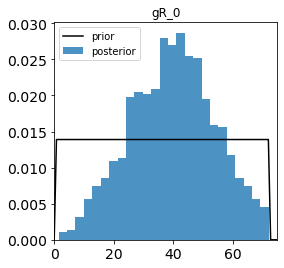

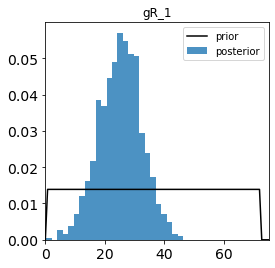

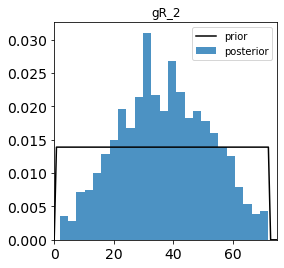

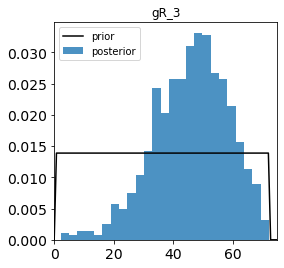

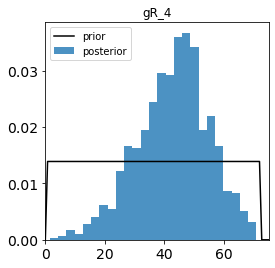

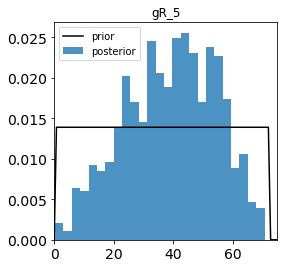

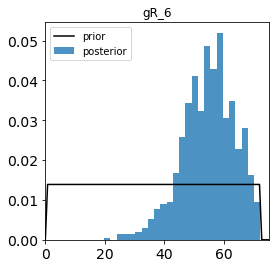

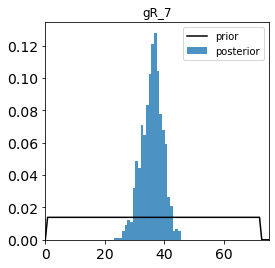

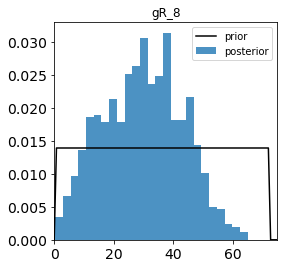

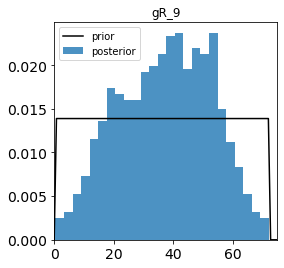

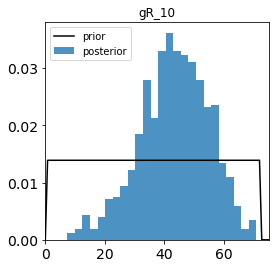

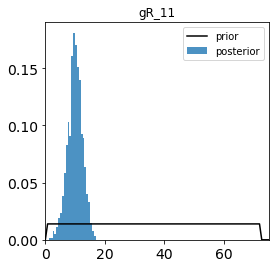

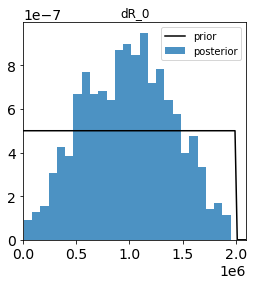

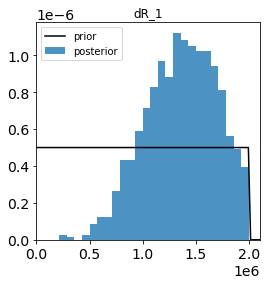

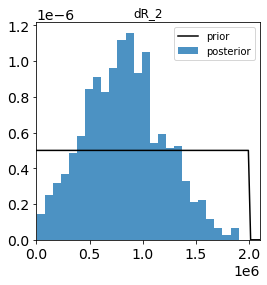

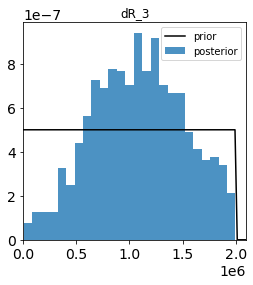

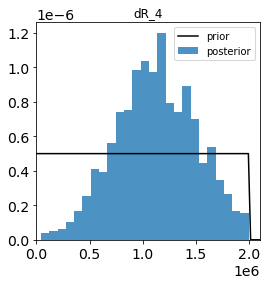

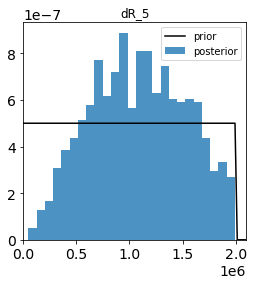

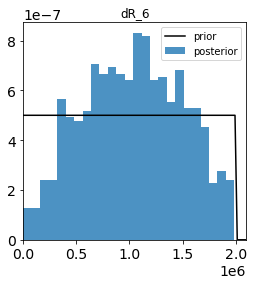

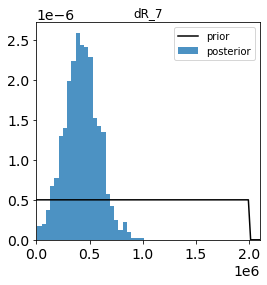

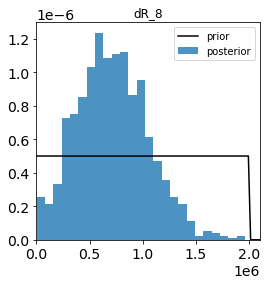

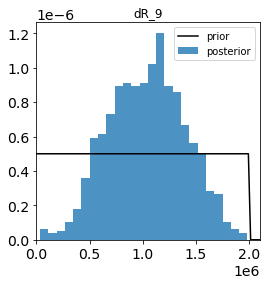

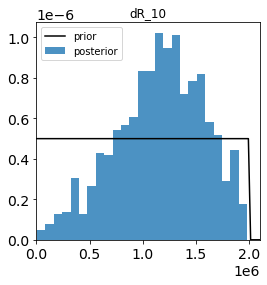

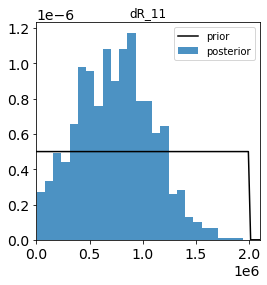

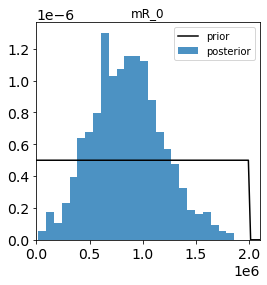

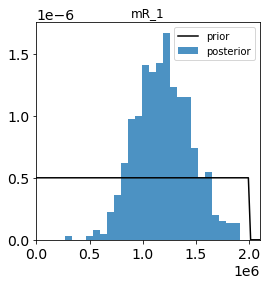

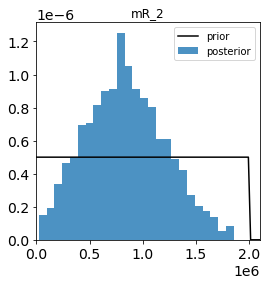

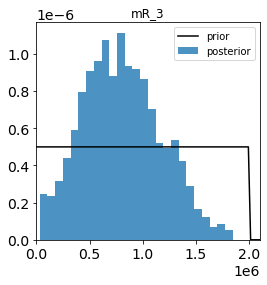

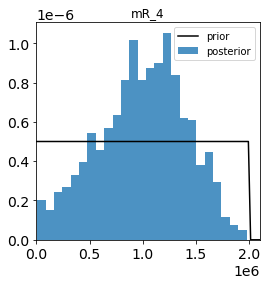

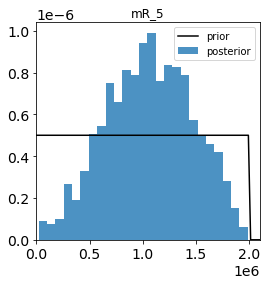

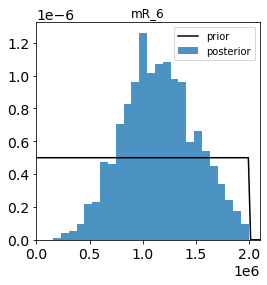

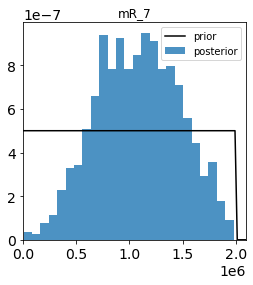

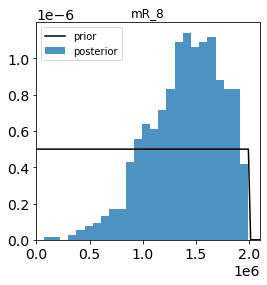

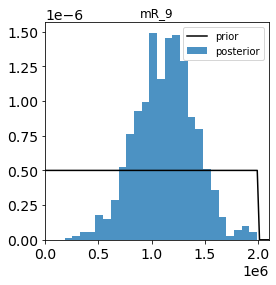

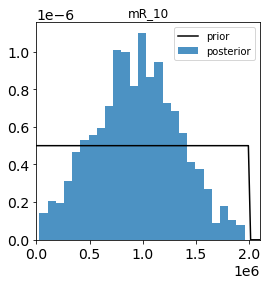

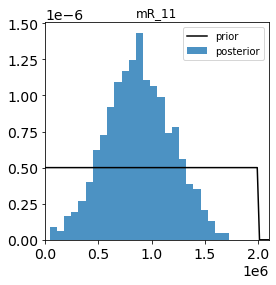

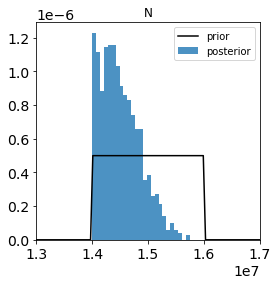

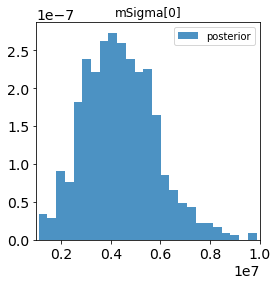

posterior: 	 ['gR_11' 'gR_1' 'gR_8' 'gR_7' 'gR_2' 'gR_9' 'gR_5' 'gR_0' 'gR_4' 'gR_10'
 'gR_3' 'gR_6'] 

posterior: 	 ['dR_7' 'dR_8' 'dR_11' 'dR_2' 'dR_0' 'dR_6' 'dR_9' 'dR_5' 'dR_3' 'dR_4'
 'dR_10' 'dR_1'] 

posterior: 	 ['mR_3' 'mR_2' 'mR_0' 'mR_11' 'mR_10' 'mR_4' 'mR_5' 'mR_7' 'mR_9' 'mR_6'
 'mR_1' 'mR_8'] 



In [30]:
gR_mean_posterior, dR_mean_posterior, mR_mean_posterior = [], [], []

posterior_dist = history_abs_abund.get_distribution(m=0,t=history_abs_abund.max_t)[0]

for par in parameter_names:
    
    par_posterior = posterior_dist.loc[:,par]
    
    x = np.linspace(limits_dict[par][0], limits_dict[par][1], 100)
    
    if par in gR_names: 
        gR_mean_posterior.append(np.mean(par_posterior))
        mp.plot(x, sp.stats.uniform.pdf(x, priors_dict[par][1], priors_dict[par][2]), color='k', label = 'prior')
        
    if par in dR_names: 
        dR_mean_posterior.append(np.mean(par_posterior))
        mp.plot(x, sp.stats.uniform.pdf(x, priors_dict[par][1], priors_dict[par][2]), color='k', label = 'prior')
    
    if par in mR_names: 
        mR_mean_posterior.append(np.mean(par_posterior))
        mp.plot(x, sp.stats.uniform.pdf(x, priors_dict[par][1], priors_dict[par][2]), color='k', label = 'prior')

    if par == 'N': 
        mp.plot(x, sp.stats.uniform.pdf(x, priors_dict[par][1], priors_dict[par][2]), color='k', label = 'prior')
        
    mp.hist(par_posterior, density=True, bins = 25, alpha=0.8, label = 'posterior')
    mp.xlim(limits_dict[par])
    mp.legend()
    mp.title('%s'%par)
    mp.show()
    
print('posterior: \t', np.array(gR_names)[np.argsort(gR_mean_posterior)],'\n')

print('posterior: \t', np.array(dR_names)[np.argsort(dR_mean_posterior)],'\n')

print('posterior: \t', np.array(mR_names)[np.argsort(mR_mean_posterior)],'\n')

In [ ]:
# abc_abs_abund_continued = ABCSMC(
#     models=model_abs_abund,
#     parameter_priors=priors,
#     distance_function=distance_abs_abund,
#     population_size=AdaptivePopulationSize(start_nr_particles=start_nr_particles_p, mean_cv = mean_cv_p, nr_calibration_particles=nr_calibration_particles_p, n_bootstrap=n_bootstrap_p, min_population_size = min_population_size_p, max_population_size = max_population_size_p),
#     transitions=MultivariateNormalTransition(scaling=scaling_p),
#     eps=QuantileEpsilon(initial_epsilon=initial_epsilon_p, alpha=alpha_p, quantile_multiplier=quantile_multiplier_p),
# )
# abc_abs_abund_continued.load(db_path_abs_abund, 54)
# history_abs_abund_continued = abc_abs_abund_continued.run(minimum_epsilon = minimum_epsilon_abs_p, max_nr_populations = 1, max_walltime = max_walltime_p)

In [ ]:
#df, w = history_abs_abund.get_distribution(m=0, t=history_abs_abund.max_t)

#ax = plot_kde_matrix(df, w, limits=limits_dict, refval=true_par, refval_color='red')
#mp.show();

#### Relative abundance

Create ABC-SMC function (consult pyABC documentation for details)

In [ ]:
abc_rel_abund = ABCSMC(
    models=logistic_model_rel_abund,
    parameter_priors=priors,
    distance_function=distance_rel_abund,
    population_size=AdaptivePopulationSize(start_nr_particles=start_nr_particles_p, mean_cv = mean_cv_p, nr_calibration_particles=nr_calibration_particles_p, n_bootstrap=n_bootstrap_p, min_population_size = min_population_size_p, max_population_size = max_population_size_p),
    transitions=MultivariateNormalTransition(scaling=scaling_p),
    eps=QuantileEpsilon(initial_epsilon=initial_epsilon_p, alpha=alpha_p, quantile_multiplier=quantile_multiplier_p),
)

Run ABC-SMC

In [ ]:
abc_rel_abund.new(db_path_rel_abund, {"moments": logistic_data_rel_abund["moments"]});

history_rel_abund = abc_rel_abund.run(minimum_epsilon = minimum_epsilon_rel_abund_p, max_nr_populations = max_nr_populations_p, max_walltime = max_walltime_p)
print('total number of simulations: %i'%history_rel_abund.total_nr_simulations)

Plot posterior

In [ ]:
gR_mean_posterior, dR_mean_posterior, mR_mean_posterior = [], [], []

posterior_dist = history_rel_abund.get_distribution()[0]

for par in parameter_names:
        
    par_posterior = posterior_dist.loc[:,par]
    
    x = np.linspace(limits_dict[par][0], limits_dict[par][1], 100)
    
    if par in gR_names: 
        gR_mean_posterior.append(np.mean(par_posterior))
        mp.plot(x, sp.stats.uniform.pdf(x, priors_dict[par][1], priors_dict[par][2]), color='k', label = 'prior')
        
    if par in dR_names: 
        dR_mean_posterior.append(np.mean(par_posterior))
        mp.plot(x, sp.stats.uniform.pdf(x, priors_dict[par][1], priors_dict[par][2]), color='k', label = 'prior')
    
    if par in mR_names: 
        mR_mean_posterior.append(np.mean(par_posterior))
        mp.plot(x, sp.stats.norm.pdf(x, priors_dict[par][1], priors_dict[par][2]), color='k', label = 'prior')

    if par == 'N': 
        mp.plot(x, sp.stats.norm.pdf(x, priors_dict[par][1], priors_dict[par][2]), color='k', label = 'prior')

    if par == 'mSigma[0]': 
        mp.plot(x, sp.stats.uniform.pdf(x, priors_dict[par][1], priors_dict[par][2]), color='k', label = 'prior')
        
    mp.hist(par_posterior, density=True, bins = 25, alpha=0.8, label = 'posterior')
    mp.axvline(true_par[par], linestyle='--', color = 'r', label = 'true')
    mp.xlim(limits_dict[par])
    mp.legend()
    mp.title(r'$%s$'%par)
    mp.show()
    
print('true: \t\t', np.array(gR_names)[np.argsort(gR)])
print('posterior: \t', np.array(gR_names)[np.argsort(gR_mean_posterior)],'\n')

print('true: \t\t', np.array(dR_names)[np.argsort(dR)])
print('posterior: \t', np.array(dR_names)[np.argsort(dR_mean_posterior)],'\n')

print('true: \t\t', np.array(mR_names)[np.argsort(mR)])
print('posterior: \t', np.array(mR_names)[np.argsort(mR_mean_posterior)],'\n')

In [ ]:
# df, w = history_rel_abund.get_distribution(m=0, t=history_rel_abund.max_t)

# ax = plot_kde_matrix(df, w, limits=limits_dict, refval=true_par, refval_color='red')
# mp.show();